In [39]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
from urllib.parse import quote

import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.alert import Alert

from datetime import datetime, timedelta

import numpy as np
import statistics
from matplotlib import font_manager, rc 
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns

#마이너스 표시
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

In [40]:
movie_df = pd.read_excel('./data/완_기간별_dropna_180101_to_230509_ver4.xlsx')
movie_df.head()

,순위,영화명,개봉일,대표국적,국적,제작사,배급사,등급,장르,감독,...,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월,개봉연도,개봉월
0,1,신과함께-죄와 벌,2017-12-20,한국,한국,"리얼라이즈픽쳐스(주),(주)덱스터스튜디오",롯데쇼핑㈜롯데엔터테인먼트,12세이상관람가,"판타지,드라마",김용화,...,7715149100,76065645532,916652,9456147,1644,7957,2018,1,2017,12
1,2,1987,2017-12-27,한국,한국,(주)우정필름,(주)씨제이이엔엠,15세이상관람가,드라마,장준환,...,4460462100,19714466137,531469,2473546,1097,4982,2018,1,2017,12
2,4,강철비,2017-12-14,한국,한국,"(주)와이웍스엔터테인먼트,(주)브이에이스튜디오",(주)넥스트엔터테인먼트월드(NEW),15세이상관람가,"액션,드라마",양우석,...,944228600,32939126166,114298,4128591,602,1451,2018,1,2017,12
3,5,위대한 쇼맨,2017-12-20,미국,미국,NaN,"월트디즈니컴퍼니코리아 유한책임회사,이십세기폭스코리아(주)",12세이상관람가,"드라마,뮤지컬",마이클 그레이시,...,509947700,7166974900,60070,874655,432,843,2018,1,2017,12
4,7,극장판 포켓몬스터 너로 정했다!,2017-12-21,일본,일본,NaN,(주)이수C&E,전체관람가,"애니메이션,어드벤처,가족",유야마 쿠니히코,...,262886500,3380416200,34103,449358,417,605,2018,1,2017,12


In [44]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156559 entries, 0 to 156558
Data columns (total 22 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   순위      156559 non-null  int64         
 1   영화명     156559 non-null  object        
 2   개봉일     156559 non-null  datetime64[ns]
 3   대표국적    156559 non-null  object        
 4   국적      156559 non-null  object        
 5   제작사     57667 non-null   object        
 6   배급사     156559 non-null  object        
 7   등급      156559 non-null  object        
 8   장르      156559 non-null  object        
 9   감독      146063 non-null  object        
 10  배우      134282 non-null  object        
 11  기준일     156559 non-null  datetime64[ns]
 12  매출액     156559 non-null  int64         
 13  누적매출액   156559 non-null  int64         
 14  관객수     156559 non-null  int64         
 15  누적관객수   156559 non-null  int64         
 16  스크린수    156559 non-null  int64         
 17  상영횟수    156559 non-null  int6

# 데이터 파악

## 상관관계로 데이터간의 관계 파악

In [45]:
movie_df_corr = movie_df[['매출액', '누적매출액', '관객수', '누적관객수', '스크린수', '상영횟수']]
corr_df = movie_df_corr.corr()
corr_df

,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수
매출액,1.000000,0.187454,0.993452,0.184219,0.689711,0.787338
누적매출액,0.187454,1.000000,0.186134,0.992930,0.243893,0.223220
관객수,0.993452,0.186134,1.000000,0.185727,0.687266,0.787833
누적관객수,0.184219,0.992930,0.185727,1.000000,0.235891,0.218123
스크린수,0.689711,0.243893,0.687266,0.235891,1.000000,0.953607
상영횟수,0.787338,0.223220,0.787833,0.218123,0.953607,1.000000


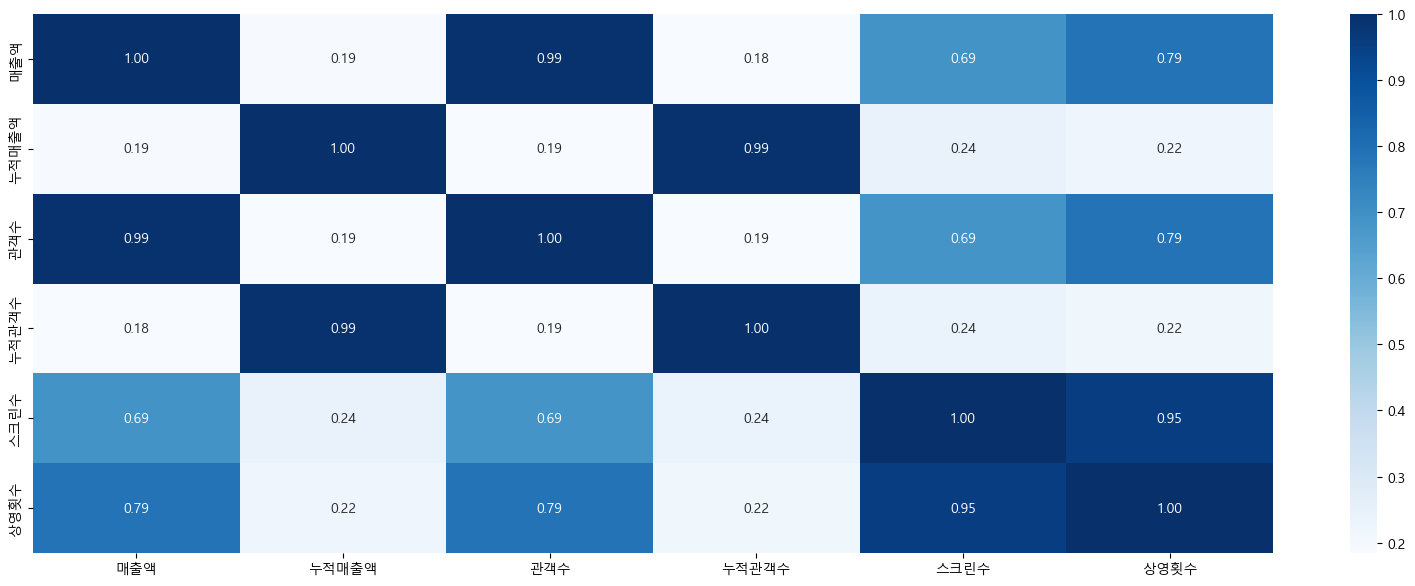

In [47]:
plt.figure(figsize=(20,7))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="Blues")
plt.show()

## 연도별 매출액, 관객, 스크린수, 상영횟수 분석

In [48]:
movie_info = movie_df[['영화명','개봉일','대표국적','등급','기준일','매출액','누적매출액','관객수','누적관객수','스크린수','상영횟수','기준연도','기준월','개봉연도','개봉월']]
movie_info_2023 = movie_info[movie_info['기준연도']==2023]
movie_info = movie_info[(movie_info['기준연도']!=2023)]
movie_info.head(3)

,영화명,개봉일,대표국적,등급,기준일,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,기준연도,기준월,개봉연도,개봉월
0,신과함께-죄와 벌,2017-12-20,한국,12세이상관람가,2018-01-01,7715149100,76065645532,916652,9456147,1644,7957,2018,1,2017,12
1,1987,2017-12-27,한국,15세이상관람가,2018-01-01,4460462100,19714466137,531469,2473546,1097,4982,2018,1,2017,12
2,강철비,2017-12-14,한국,15세이상관람가,2018-01-01,944228600,32939126166,114298,4128591,602,1451,2018,1,2017,12


In [49]:
movie_year_info = movie_info.groupby(['기준연도']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_year_info

,매출액,관객수,스크린수,상영횟수
기준연도,,,,
2018,1803053513874,214800472,2045526,6481407
2019,1905775613740,225348538,2202714,6819125
2020,499807403001,57991182,1699936,4230443
2021,575737801570,59492525,1915741,4550562
2022,1156311543025,112287213,2085867,5653084


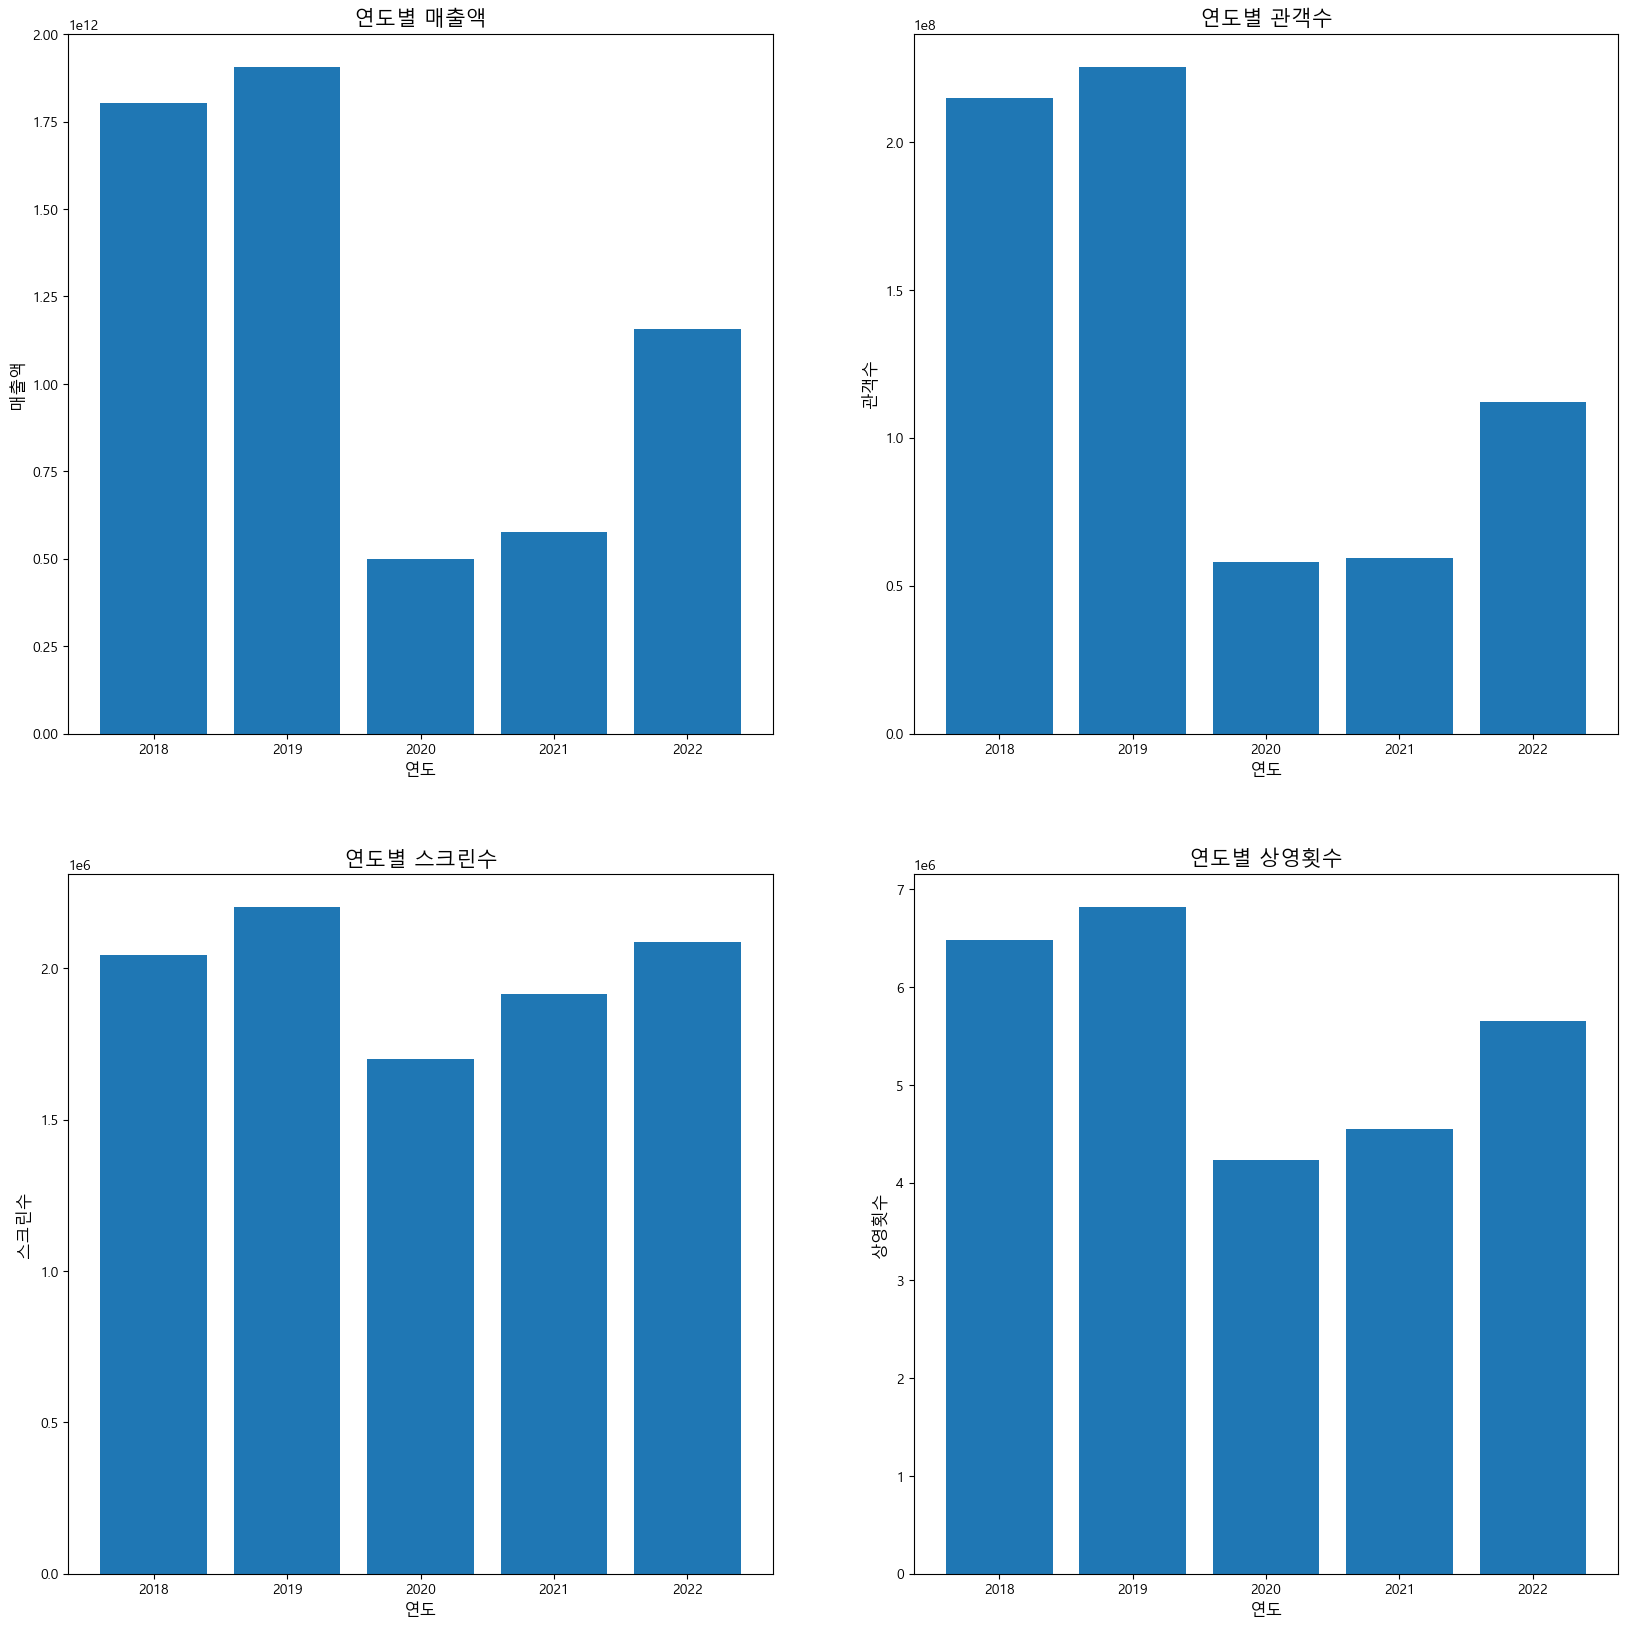

In [50]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2,2,1)
ax1.bar(movie_year_info['매출액'].index, movie_year_info['매출액'].values)

ax1.set_title('연도별 매출액', size=15)
ax1.set_xlabel('연도',size=12)
ax1.set_ylabel('매출액',size=12)

ax2 = fig.add_subplot(2,2,2)
ax2.bar(movie_year_info['관객수'].index, movie_year_info['관객수'].values)

ax2.set_title('연도별 관객수', size=15)
ax2.set_xlabel('연도',size=12)
ax2.set_ylabel('관객수',size=12)

ax3 = fig.add_subplot(2,2,3)
ax3.bar(movie_year_info['스크린수'].index, movie_year_info['스크린수'].values)

ax3.set_title('연도별 스크린수', size=15)
ax3.set_xlabel('연도',size=12)
ax3.set_ylabel('스크린수',size=12)

ax4 = fig.add_subplot(2,2,4)
ax4.bar(movie_year_info['상영횟수'].index, movie_year_info['상영횟수'].values)

ax4.set_title('연도별 상영횟수', size=15)
ax4.set_xlabel('연도',size=12)
ax4.set_ylabel('상영횟수',size=12)

plt.show()

In [ ]:
# 총매출은 관객수가 관련이 깊다
# 매출을 늘리기 위해선 관객의 니즈를 파악하는것이 중요!!

# 연도별로 월별 총매출 비교 분석

In [51]:
movie_year_month_info = movie_info.groupby(['기준연도','기준월']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_year_month_info

매출액       관객수    스크린수    상영횟수
기준연도 기준월                                        
2018 1    182570933055  22855349  178493  540544
     2    125577168604  15419584  167930  498096
     3    103247443080  12712628  170192  539987
     4    119012943079  13965670  165378  522097
     5    138604323723  15841521  158706  524401
     6    130064963730  15008176  157343  521914
     7    165196733758  19628200  164953  558506
     8    251512849720  30118731  180436  573365
     9    143012857199  16696746  169636  559188
     10   117864380879  13846326  171068  558133
     11   142799159077  16880096  163068  516526
     12   183589757970  21827445  198323  568650
2019 1    150642511096  18039194  207053  571813
     2    188837779100  22117218  169481  540451
     3    126063124169  14587859  178920  559610
     4    112557878860  13240610  173439  501733
     5    154084279784  17980182  169653  539657
     6    193410126770  22592502  166170  547142
     7    183471335654  21808456  185621  594051
     8    208508949348  24695242  204292  631832
     9    123735469044  14609600  187985  557225
     10   123289112660  14770364  179838  577520
     11   154985018555  18522064  179793  585248
     12   186190028700  22385247  200469  612843
2020 1    143241268330  16764628  199312  605259
     2     61288986040   7243587  157385  487750
     3     13750184050   1608244  118462  236229
     4      6464392100    785177   80585  129337
     5     11757677380   1421263  133759  217167
     6     31729156620   3719875  133610  327257
     7     45893449550   5432258  145525  415831
     8     76331690039   8722077  154987  488045
     9     25671735652   2936219  136965  342297
     10    41120417960   4573624  166234  398591
     11    31057749810   3451711  141265  347968
     12    11500695470   1332519  131847  234712
2021 1     14757173490   1663695  109773  198686
     2     27326517230   2956945  133918  289057
     3     28195246720   3065133  148733  307110
     4     23211632320   2516203  154361  322626
     5     40156952120   4268374  171067  358469
     6     46785738940   4895030  158022  400910
     7     68001647640   6920842  174413  455929
     8     76171187340   7877177  171789  482177
     9     51238098193   5299796  175481  430963
     10    50330763630   5123998  170630  427237
     11    65516259119   6458853  171101  453664
     12    84046584828   8446479  176453  423734
2022 1     55494540020   5698426  173492  442932
     2     30636350090   3230627  153760  365712
     3     26844822720   2772014  161925  364243
     4     30076613310   3073924  159226  379532
     5    150418376910  14509939  159775  528386
     6    158009480790  15450430  156024  522306
     7    170096315665  16231138  185465  564496
     8    152130935750  14926611  196768  565201
     9    101645205347   9824043  174162  496599
     10    60914620218   6126650  200226  491663
     11    63163069397   6337508  173141  447516
     12   156881212808  14105903  191903  484498

In [52]:
movie_month_info = movie_info.groupby(['기준월']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_month_info

,매출액,관객수,스크린수,상영횟수
기준월,,,,
1,546706425991,65021292,868123,2359234
2,433666801064,50967961,782474,2181066
3,298100820739,34745878,778232,2007179
4,291323459669,33581584,732989,1855325
5,495021609917,54021279,792960,2168080
6,559999466850,61666013,771169,2319529
7,632659482267,70020894,855977,2588813
8,764655612197,86339838,908272,2740620
9,445303365435,49366404,844229,2386272


In [53]:
movie_year_month_info_2023 = movie_info_2023.groupby(['기준연도','기준월']).agg({'매출액':'sum', '관객수':'sum', '스크린수':'sum', '상영횟수':'sum'})
movie_year_month_info_2023[:-1]

매출액       관객수    스크린수    상영횟수
기준연도 기준월                                        
2023 1    123808074711  11220380  207405  525120
     2     62335465454   5942445  186764  427956
     3     79804374946   7445640  190480  465873
     4     69957651381   6902721  174795  437812

In [54]:
movie_year_month_info.loc[2022]['매출액']

기준월
1      55494540020
2      30636350090
3      26844822720
4      30076613310
5     150418376910
6     158009480790
7     170096315665
8     152130935750
9     101645205347
10     60914620218
11     63163069397
12    156881212808
Name: 매출액, dtype: int64

In [55]:
month_list = movie_year_month_info.loc[2022]['매출액'].index.map(lambda x: str(x)).to_list()
month_list

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

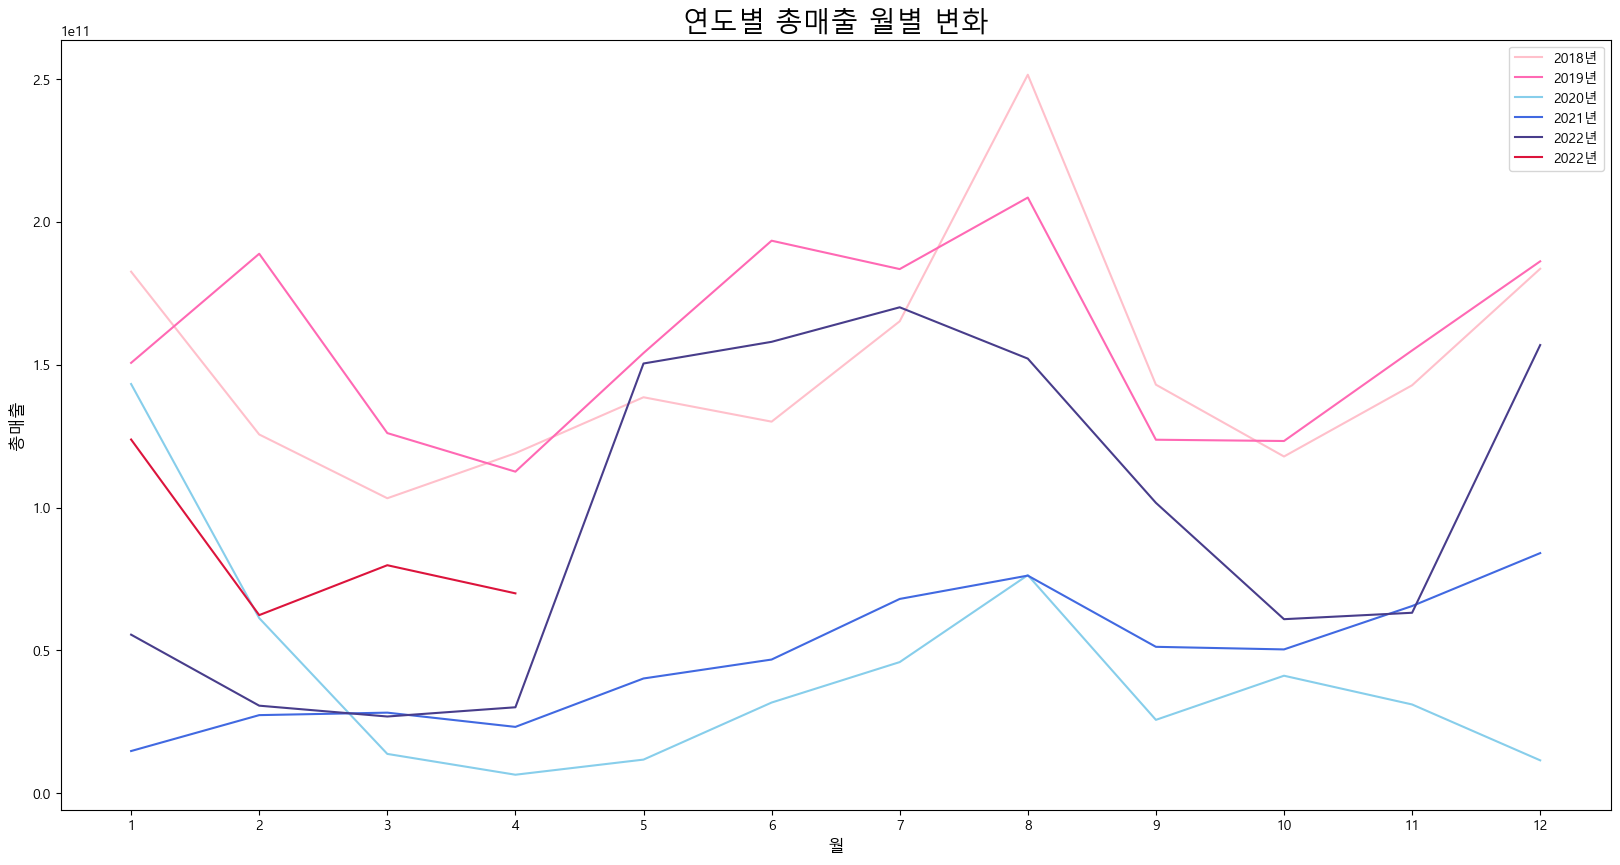

In [56]:
# 연도별 월별 총매출 시각화
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

month_list = movie_year_month_info.loc[2022]['매출액'].index.map(lambda x: str(x)).to_list()

ax.plot(month_list,movie_year_month_info.loc[2018]['매출액'], color="pink", label="2018년")
ax.plot(month_list,movie_year_month_info.loc[2019]['매출액'], color="hotpink", label="2019년")
ax.plot(month_list,movie_year_month_info.loc[2020]['매출액'], color="skyblue", label="2020년")
ax.plot(month_list,movie_year_month_info.loc[2021]['매출액'], color="royalblue", label="2021년")
ax.plot(month_list,movie_year_month_info.loc[2022]['매출액'], color="darkslateblue", label="2022년")
ax.plot(month_list[:4],movie_year_month_info_2023[:-1].loc[2023]['매출액'], color="crimson", label="2022년")

ax.legend(loc="best")
ax.set_title('연도별 총매출 월별 변화', size=20)
ax.set_xlabel('월',size=12)
ax.set_ylabel('총매출',size=12)
plt.show()

In [57]:
# 연도별로봤을때 3, 4월에 매출이 가장 적고 8월에 가장 많이 발생 - 장르 비교?
# 월별로 어떤 영화의 매출이 가장 높았는가?
# 그 분기에 가장 많이 성공한 영화?
# 그 월에 개봉한 영화수?+
# 개봉후 첫 주말
# 2023.05 63819008412
# 2023.04 70688545576

# 분기별 매출 분석

In [58]:
sales_quarter = movie_df[['영화명','기준연도','기준월','매출액','관객수','장르']].copy()
sales_quarter

,영화명,기준연도,기준월,매출액,관객수,장르
0,신과함께-죄와 벌,2018,1,7715149100,916652,"판타지,드라마"
1,1987,2018,1,4460462100,531469,드라마
2,강철비,2018,1,944228600,114298,"액션,드라마"
3,위대한 쇼맨,2018,1,509947700,60070,"드라마,뮤지컬"
4,극장판 포켓몬스터 너로 정했다!,2018,1,262886500,34103,"애니메이션,어드벤처,가족"
...,...,...,...,...,...,...
156554,"안녕, 티라노: 영원히, 함께",2023,5,16000,2,애니메이션
156555,차별,2023,5,5000,1,다큐멘터리
156556,미나리,2023,5,48000,4,드라마
156557,어떤 영웅,2023,5,17000,2,드라마


In [59]:
def quarter_category(month):
    quarter = "-"
    if month <= 3:
        quarter = "1분기"
    elif month <= 6:
        quarter = "2분기"
    elif month <= 9:
        quarter = "3분기"
    elif month <= 12:
        quarter = "4분기"
    else:
        quarter = "-"
    return quarter

sales_quarter['분기'] = sales_quarter['기준월'].apply(lambda x : quarter_category(x))
sales_quarter.head(1)

,영화명,기준연도,기준월,매출액,관객수,장르,분기
0,신과함께-죄와 벌,2018,1,7715149100,916652,"판타지,드라마",1분기


In [60]:
sales_quarter_year = sales_quarter.groupby(['기준연도', '분기'])['매출액'].agg(['sum'])
sales_quarter_year.reset_index(inplace=True)
sales_quarter_year

,기준연도,분기,sum
0,2018,1분기,411395544739
1,2018,2분기,387682230532
2,2018,3분기,559722440677
3,2018,4분기,444253297926
4,2019,1분기,465543414365
5,2019,2분기,460052285414
6,2019,3분기,515715754046
7,2019,4분기,464464159915
8,2020,1분기,218280438420
9,2020,2분기,49951226100


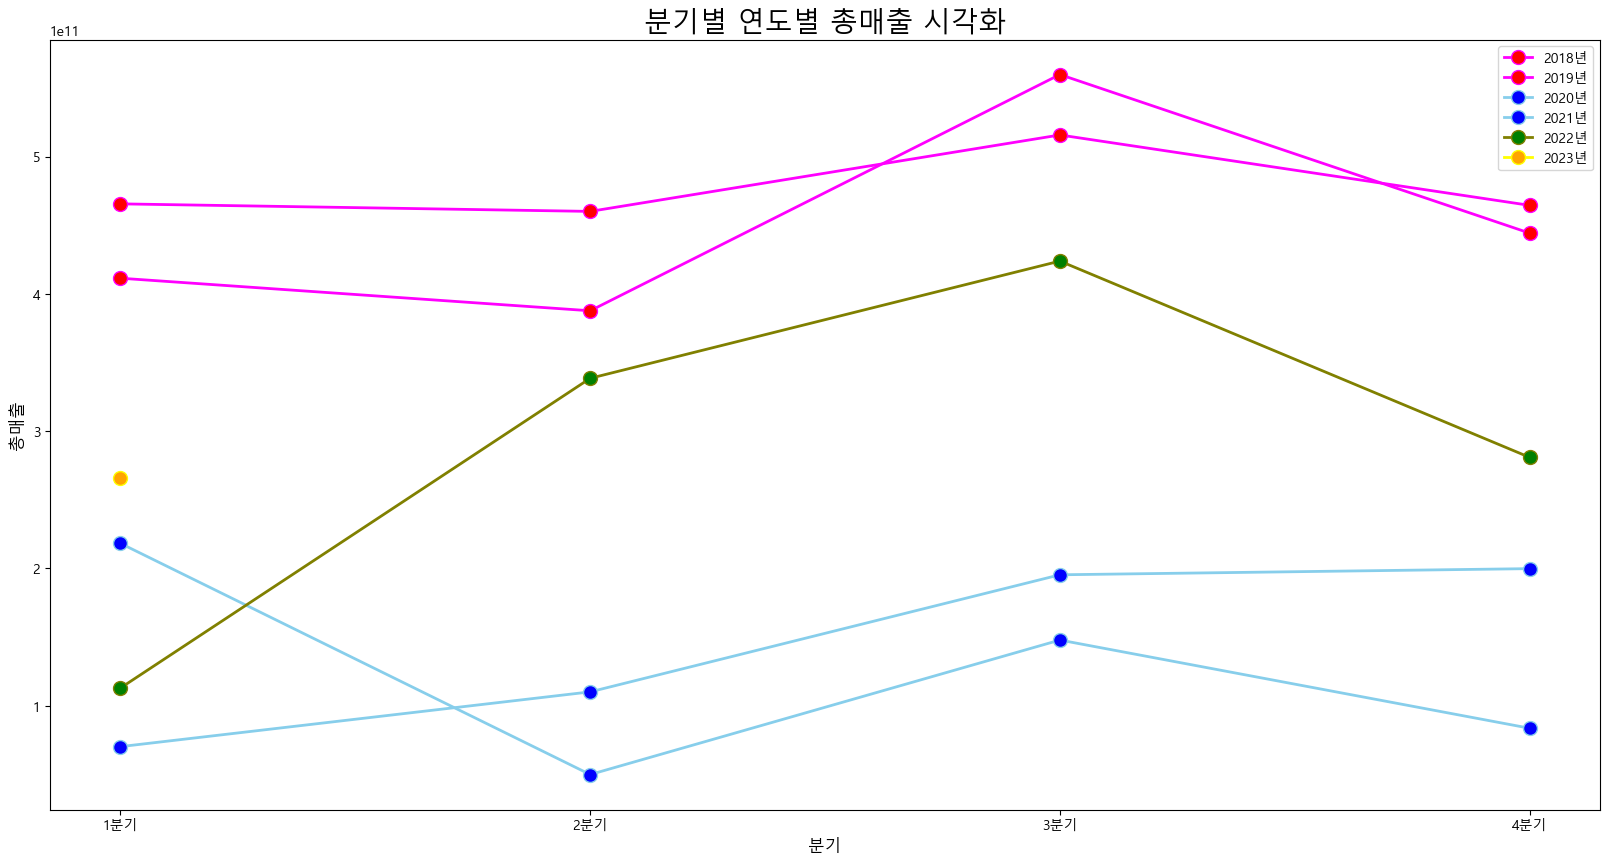

In [62]:
# 분기별 연도별 시각화
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

sales_quarter_year_2018 = sales_quarter_year[sales_quarter_year["기준연도"]==2018]
sales_quarter_year_2019 = sales_quarter_year[sales_quarter_year["기준연도"]==2019]
sales_quarter_year_2020 = sales_quarter_year[sales_quarter_year["기준연도"]==2020]
sales_quarter_year_2021 = sales_quarter_year[sales_quarter_year["기준연도"]==2021]
sales_quarter_year_2022 = sales_quarter_year[sales_quarter_year["기준연도"]==2022]
sales_quarter_year_2023 = sales_quarter_year[sales_quarter_year["기준연도"]==2023][:-1]

ax.plot(sales_quarter_year_2018['분기'], sales_quarter_year_2018['sum'], marker='o', markerfacecolor='red',
        markersize=10, color ="magenta", linewidth=2, label='2018년')
ax.plot(sales_quarter_year_2019['분기'], sales_quarter_year_2019['sum'], marker='o', markerfacecolor='red',
        markersize=10, color ="magenta", linewidth=2, label='2019년')
ax.plot(sales_quarter_year_2020['분기'], sales_quarter_year_2020['sum'], marker='o', markerfacecolor='blue',
        markersize=10, color ="skyblue", linewidth=2, label='2020년')
ax.plot(sales_quarter_year_2021['분기'], sales_quarter_year_2021['sum'], marker='o', markerfacecolor='blue',
        markersize=10, color ="skyblue", linewidth=2, label='2021년')
ax.plot(sales_quarter_year_2022['분기'], sales_quarter_year_2022['sum'], marker='o', markerfacecolor='green',
        markersize=10, color ="olive", linewidth=2, label='2022년')
ax.plot(sales_quarter_year_2023['분기'], sales_quarter_year_2023['sum'], marker='o', markerfacecolor='orange',
        markersize=10, color ="yellow", linewidth=2, label='2023년')


ax.legend(loc="best")
ax.set_title('분기별 연도별 총매출 시각화', size=20)
ax.set_xlabel('분기',size=12)
ax.set_ylabel('총매출',size=12)
# ax.set_xticklabels(col_years, rotation = 90)
plt.show()

# 매출 발생이 가장 높은달(8월)과 낮은달(4월) 비교

## 매출 천만원 넘은 영화 장르

In [63]:
April_sales_movie = month_movie_sales[month_movie_sales["기준월"]==4]
August_sales_movie = month_movie_sales[month_movie_sales["기준월"]==8]
April_sales_movie = April_sales_movie.sort_values(["매출액"],axis=0, ascending=False)
August_sales_movie = August_sales_movie.sort_values(["매출액"],axis=0, ascending=False)

In [64]:
April_sales_movie_top = April_sales_movie[April_sales_movie['매출액']>5000000].reset_index()
August_sales_movie_top = August_sales_movie[August_sales_movie['매출액']>5000000].reset_index()

In [65]:
April_sales_movie_top

,영화명,개봉일,기준연도,기준월,매출액
0,어벤져스: 엔드게임,2019-04-24,2019,4,63197528530
1,어벤져스: 인피니티 워,2018-04-25,2018,4,46128544531
2,레디 플레이어 원,2018-03-28,2018,4,13863899642
3,곤지암,2018-03-28,2018,4,13733316070
4,램페이지,2018-04-12,2018,4,11895097696
...,...,...,...,...,...
434,인생 후르츠,2018-12-06,2019,4,5169000
435,누구나 아는 비밀,2019-08-01,2019,4,5147000
436,도우터 오브 마인,2019-04-25,2019,4,5142360
437,사바하,2019-02-20,2019,4,5066300


In [66]:
merge_df = movie_df[["영화명","장르"]].drop_duplicates()
merge_df

,영화명,장르
0,신과함께-죄와 벌,"판타지,드라마"
1,1987,드라마
2,강철비,"액션,드라마"
3,위대한 쇼맨,"드라마,뮤지컬"
4,극장판 포켓몬스터 너로 정했다!,"애니메이션,어드벤처,가족"
...,...,...
156268,스트리머,"공포(호러),미스터리"
156270,엑소시스트: 더 바티칸,공포(호러)
156347,바람개비,액션
156382,대물에 놀아난 여자,성인물(에로)


In [67]:
April_top = pd.merge(April_sales_movie_top,merge_df,
                     left_on = "영화명",right_on = "영화명", how='left')
August_top = pd.merge(August_sales_movie_top,merge_df,
                     left_on = "영화명",right_on = "영화명", how='left')

In [68]:
movie_genre = movie_df[['영화명','개봉일','기준연도','기준월','매출액','관객수','장르']].copy()
movie_genre.dropna(subset=["장르"],inplace=True)

In [69]:
genre = []
for li in movie_genre['장르'].unique():
    if ',' in li:
        pass
    else:
        genre.append(li)
len(genre)

21

In [70]:
# 장르별 컬럼 만들기
for col in genre:
    April_top[col]=0
    August_top[col]=0
    
April_top.head(3)
August_top.head(3)

,영화명,개봉일,기준연도,기준월,매출액,장르,드라마,애니메이션,스릴러,다큐멘터리,...,공포(호러),기타,사극,서부극(웨스턴),어드벤처,미스터리,뮤지컬,판타지,전쟁,가족
0,신과함께-인과 연,2018-08-01,2018,8,100553061209,"판타지,드라마",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,엑시트,2019-07-31,2019,8,70494628112,"코미디,액션",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,한산: 용의 출현,2022-07-27,2022,8,48640449693,"액션,드라마",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
for col in genre:
    April_top[col]=April_top["장르"].apply(lambda x: 1 if col in x else 0)
    August_top[col]=August_top["장르"].apply(lambda x: 1 if col in x else 0)

In [72]:
April_top.head(2)

,영화명,개봉일,기준연도,기준월,매출액,장르,드라마,애니메이션,스릴러,다큐멘터리,...,공포(호러),기타,사극,서부극(웨스턴),어드벤처,미스터리,뮤지컬,판타지,전쟁,가족
0,어벤져스: 엔드게임,2019-04-24,2019,4,63197528530,"액션,SF",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,어벤져스: 인피니티 워,2018-04-25,2018,4,46128544531,"액션,어드벤처,판타지,SF",0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [73]:
April_genre_df = April_top.iloc[:,6:]
April_total_genre = April_genre_df.sum(axis=0)
April_total_genre.sort_values(ascending=False, inplace=True)
April_total_genre_df = April_total_genre[:10]
April_total_genre_df['others'] = April_total_genre[10:].sum(axis=0)

August_genre_df = August_top.iloc[:,6:]
August_total_genre = August_genre_df.sum(axis=0)
August_total_genre.sort_values(ascending=False, inplace=True)
August_total_genre_df = August_total_genre[:10]
August_total_genre_df['others'] = August_total_genre[10:].sum(axis=0)

In [74]:
len(April_total_genre_df)

11

In [75]:
# 색상 맵 선택
cmap = cm.get_cmap('tab20c')
colors = cmap(np.array(range(1,50)))

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_11896\1826526935.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


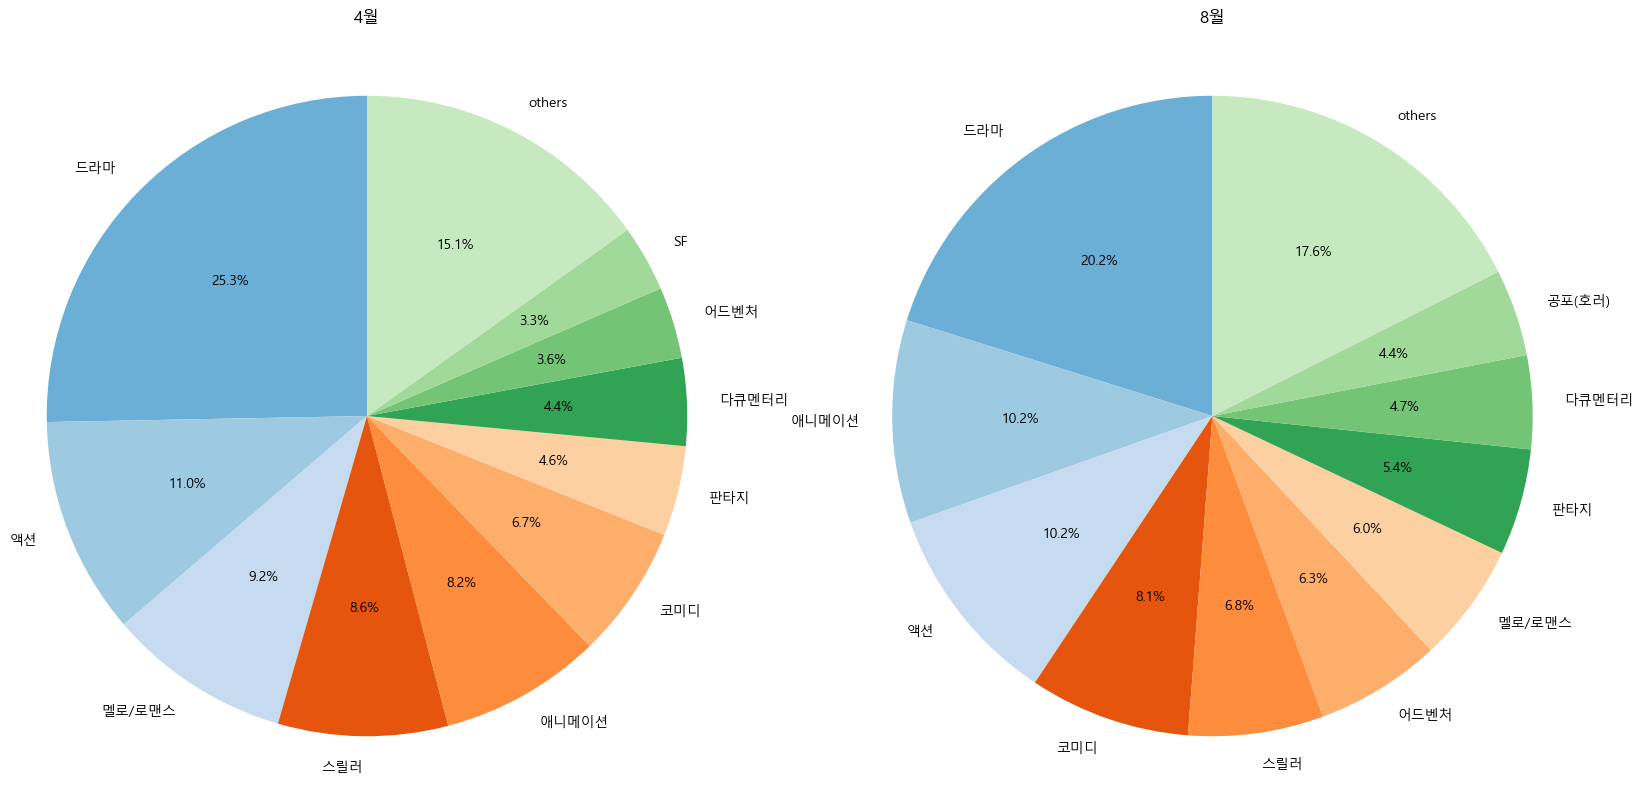

In [90]:
# 매출 높게 발생한 영화 장르 비교
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.pie(April_total_genre_df.values.flatten(), labels=April_total_genre_df.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax2.pie(August_total_genre_df.values.flatten(), labels=August_total_genre_df.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax1.set_title('4월')
ax1.axis('equal')
ax2.set_title('8월')
ax2.axis('equal')

plt.show()

## 4월과 8월에 개봉한 영화 장르

In [80]:
open_movie = movie_df[['영화명','개봉연도','개봉월','매출액','장르']].copy()
open_movie.dropna(subset=["장르"],inplace=True)
open_movie.drop_duplicates(inplace=True)
open_movie

,영화명,개봉연도,개봉월,매출액,장르
0,신과함께-죄와 벌,2017,12,7715149100,"판타지,드라마"
1,1987,2017,12,4460462100,드라마
2,강철비,2017,12,944228600,"액션,드라마"
3,위대한 쇼맨,2017,12,509947700,"드라마,뮤지컬"
4,극장판 포켓몬스터 너로 정했다!,2017,12,262886500,"애니메이션,어드벤처,가족"
...,...,...,...,...,...
156553,환상의 마로나,2020,6,71000,"애니메이션,드라마,가족"
156554,"안녕, 티라노: 영원히, 함께",2019,8,16000,애니메이션
156556,미나리,2021,3,48000,드라마
156557,어떤 영웅,2023,3,17000,드라마


In [81]:
open_movie_df = open_movie.groupby(["영화명","개봉연도","개봉월"])["매출액"].sum().to_frame().reset_index().set_index('영화명')
open_movie_df = open_movie_df[(open_movie_df["개봉연도"]!=2017)&(open_movie_df["개봉연도"]!=2023)]
open_movie_df

,개봉연도,개봉월,매출액
영화명,,,
#살아있다,2020,6,15968190400
#아이엠히어,2021,1,136875710
#위왓치유,2021,6,15868950
#해시태그,2022,6,2205600
0.0MHz,2019,5,1088253860
...,...,...,...
힐링하우스 : 섹스의 왕국,2022,5,6000
힐빌리의 노래,2020,11,33965080
힘 좋은 시아버지와 착한 며느리,2021,3,100000


In [82]:
April_open_movie = open_movie_df[open_movie_df["개봉월"]==4]
August_open_movie = open_movie_df[open_movie_df["개봉월"]==8]
April_open_movie = April_open_movie.sort_values(["매출액"],axis=0, ascending=False)
August_open_movie = August_open_movie.sort_values(["매출액"],axis=0, ascending=False)

In [83]:
April_open_movie_top = April_open_movie[April_open_movie['매출액']>1000000]
August_open_movie_top = August_open_movie[August_open_movie['매출액']>1000000]

In [84]:
April_open_top = pd.merge(April_open_movie_top,merge_df,
                     left_on = "영화명",right_on = "영화명", how='left')
August_open_top = pd.merge(August_open_movie_top,merge_df,
                     left_on = "영화명",right_on = "영화명", how='left')

In [85]:
# 장르별 컬럼 만들기
for col in genre:
    April_open_top[col]=0
    August_open_top[col]=0
    
April_open_top.head(3)
August_open_top.head(3)

,영화명,개봉연도,개봉월,매출액,장르,드라마,애니메이션,스릴러,다큐멘터리,멜로/로맨스,...,공포(호러),기타,사극,서부극(웨스턴),어드벤처,미스터리,뮤지컬,판타지,전쟁,가족
0,신과함께-인과 연,2018,8,102689023539,"판타지,드라마",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,헌트,2022,8,44599068153,"액션,공포(호러),스릴러",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,헌트,2022,8,44599068153,"액션,드라마",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
for col in genre:
    April_open_top[col]=April_open_top["장르"].apply(lambda x: 1 if col in x else 0)
    August_open_top[col]=August_open_top["장르"].apply(lambda x: 1 if col in x else 0)

In [87]:
April_open_genre_df = April_open_top.iloc[:,6:]
April_open_total_genre = April_open_genre_df.sum(axis=0)
April_open_total_genre.sort_values(ascending=False, inplace=True)
April_open_total_genre_df = April_open_total_genre[:10]
April_open_total_genre_df['others'] = April_open_total_genre[10:].sum(axis=0)


August_open_genre_df = August_open_top.iloc[:,6:]
August_open_total_genre = August_open_genre_df.sum(axis=0)
August_open_total_genre.sort_values(ascending=False, inplace=True)
August_open_total_genre_df = August_open_total_genre[:10]
August_open_total_genre_df['others'] = August_open_total_genre[10:].sum(axis=0)

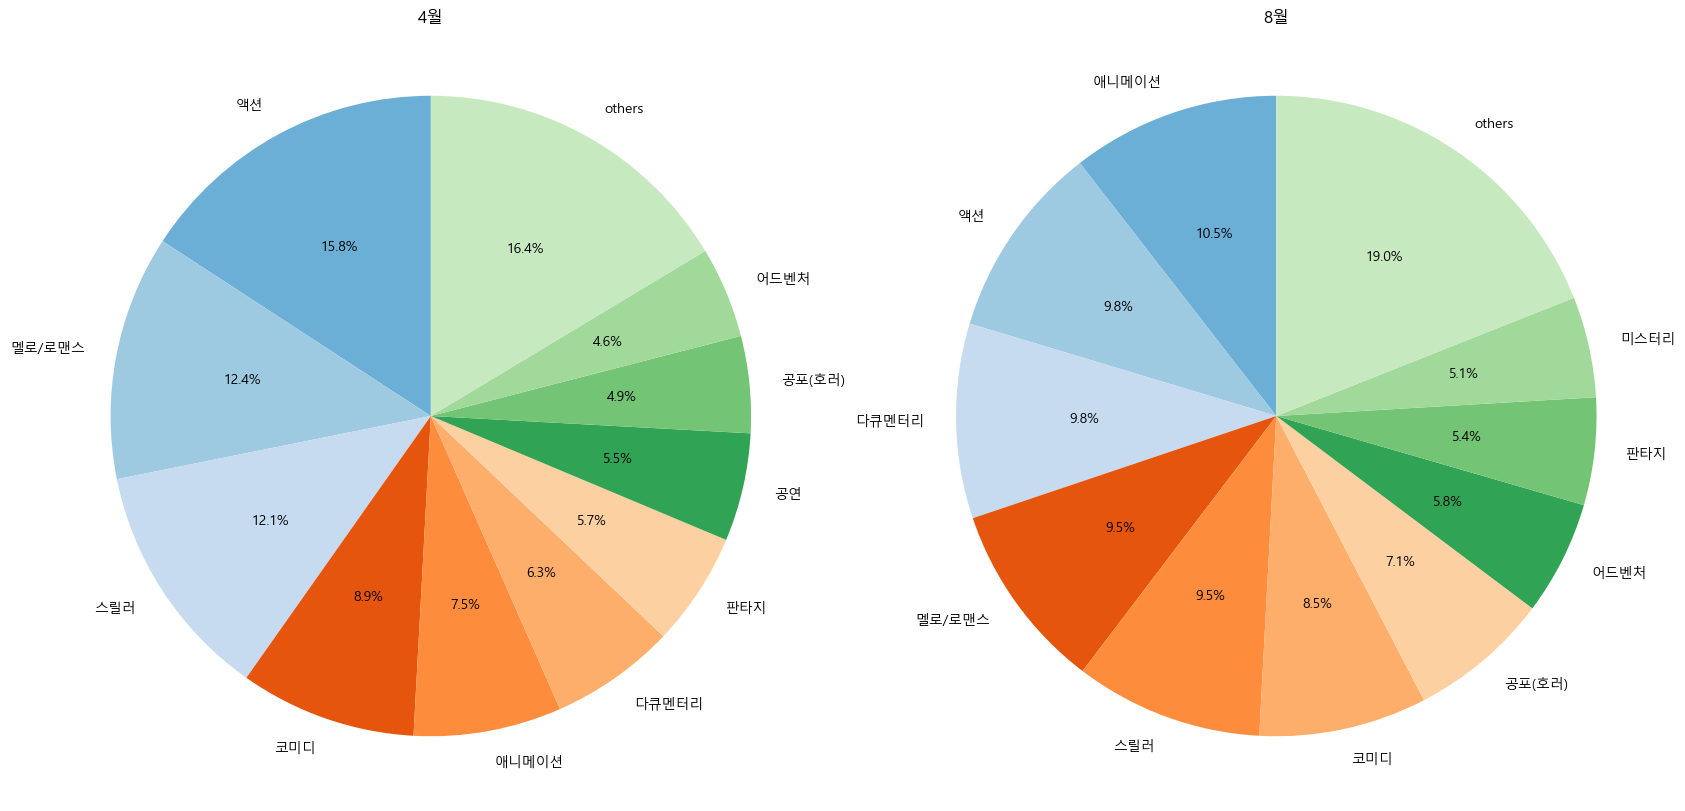

In [91]:
# 개봉한 영화 장르 비교
fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.pie(April_open_total_genre_df.values.flatten(), labels=April_open_total_genre_df.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax2.pie(August_open_total_genre_df.values.flatten(), labels=August_open_total_genre_df.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax1.set_title('4월')
ax1.axis('equal')
ax2.set_title('8월')
ax2.axis('equal')

plt.show()

# 연도별 개봉한 영화수

In [100]:
open_count = movie_df[['영화명','개봉연도','개봉월']].copy()
open_count.drop_duplicates(inplace=True)

print(len(movie_df_info)) 
print(len(open_count))

156559
10088


In [102]:
open_count_df = open_count.groupby(['개봉연도'])['영화명'].count().to_frame()
open_count_df

,영화명
개봉연도,
2017,297
2018,1819
2019,1929
2020,1894
2021,1857
2022,1773
2023,519


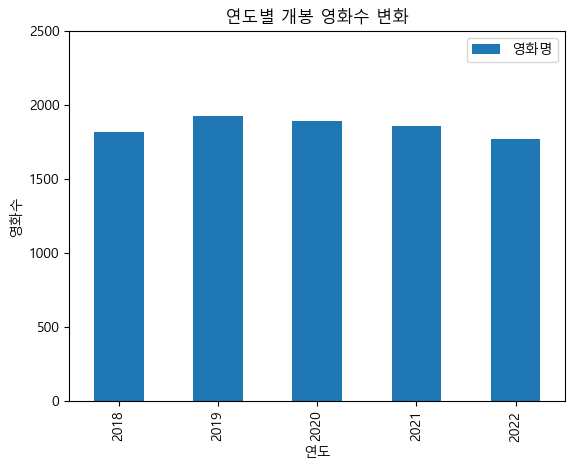

In [108]:
open_count_df[['영화명']][1:-1].plot(kind='bar')
plt.title("연도별 개봉 영화수 변화")
plt.xlabel('연도')
plt.ylabel('영화수')
plt.ylim(0,2500)
plt.show()

# 등급별 총매출

In [114]:
movie_grade = movie_df[['영화명', '등급','개봉연도','개봉월','기준연도','기준월','매출액','관객수']]
movie_grade

,영화명,등급,개봉연도,개봉월,기준연도,기준월,매출액,관객수
0,너의 이름은.,12세이상관람가,2017,1,2017,1,2809088900,333008
1,모아나,전체관람가,2017,1,2017,1,7738000,910
2,패신저스,12세이상관람가,2017,1,2017,1,1107502600,129810
3,눈의 여왕 3: 눈과 불의 마법대결,전체관람가,2017,1,2017,1,535436000,67605
4,사랑하기 때문에,12세이상관람가,2017,1,2017,1,450612400,53856
...,...,...,...,...,...,...,...,...
183001,돈 지오반니,전체관람가,2017,1,2017,1,4881000,209
183002,걱정말아요,청소년관람불가,2017,1,2017,1,502000,71
183003,비밀객잔의 결투,12세이상관람가,2017,1,2017,1,7000,2
183004,소림사 무림 탐정-취의전장,12세이상관람가,2017,1,2017,1,7000,2


In [115]:
grade_df = movie_grade[movie_grade['등급'].isnull()==False]
grade_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183004 entries, 0 to 183005
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   영화명     183004 non-null  object
 1   등급      183004 non-null  object
 2   개봉연도    183004 non-null  int64 
 3   개봉월     183004 non-null  int64 
 4   기준연도    183004 non-null  int64 
 5   기준월     183004 non-null  int64 
 6   매출액     183004 non-null  int64 
 7   관객수     183004 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 12.6+ MB


In [116]:
len(grade_df)

183004

In [117]:
grade_df_기준연도 = grade_df.groupby(['등급','기준연도'])['매출액'].agg(['sum'])
grade_df_기준연도

sum
등급       기준연도              
12세이상관람가 2017  540038507289
         2018  990028175503
         2019  722164864226
         2020  158637461033
         2021  284229922769
         2022  634026994169
         2023  257801647911
15세이상관람가 2017  794981752862
         2018  577936937068
         2019  684695135722
         2020  269363764436
         2021  193442625960
         2022  416067429361
         2023   45424363163
전체관람가    2017  177191677466
         2018  150154861593
         2019  427362676004
         2020   55208589132
         2021   63932537661
         2022   91203166657
         2023   45500344027
청소년관람불가  2017  192476149846
         2018   85603988560
         2019   71566540788
         2020   16599088400
         2021   34132805680
         2022   15014000838
         2023   21625642510

In [118]:
grade_df_기준연도.columns=["총매출"]
grade_df_기준연도.reset_index(inplace=True)
grade_df_기준연도.head()

,등급,기준연도,총매출
0,12세이상관람가,2017,540038507289
1,12세이상관람가,2018,990028175503
2,12세이상관람가,2019,722164864226
3,12세이상관람가,2020,158637461033
4,12세이상관람가,2021,284229922769


In [119]:
grade_df_기준연도['총매출'] = round(grade_df_기준연도['총매출']/1000000,1)
grade_df_기준연도.head()

,등급,기준연도,총매출
0,12세이상관람가,2017,540038.5
1,12세이상관람가,2018,990028.2
2,12세이상관람가,2019,722164.9
3,12세이상관람가,2020,158637.5
4,12세이상관람가,2021,284229.9


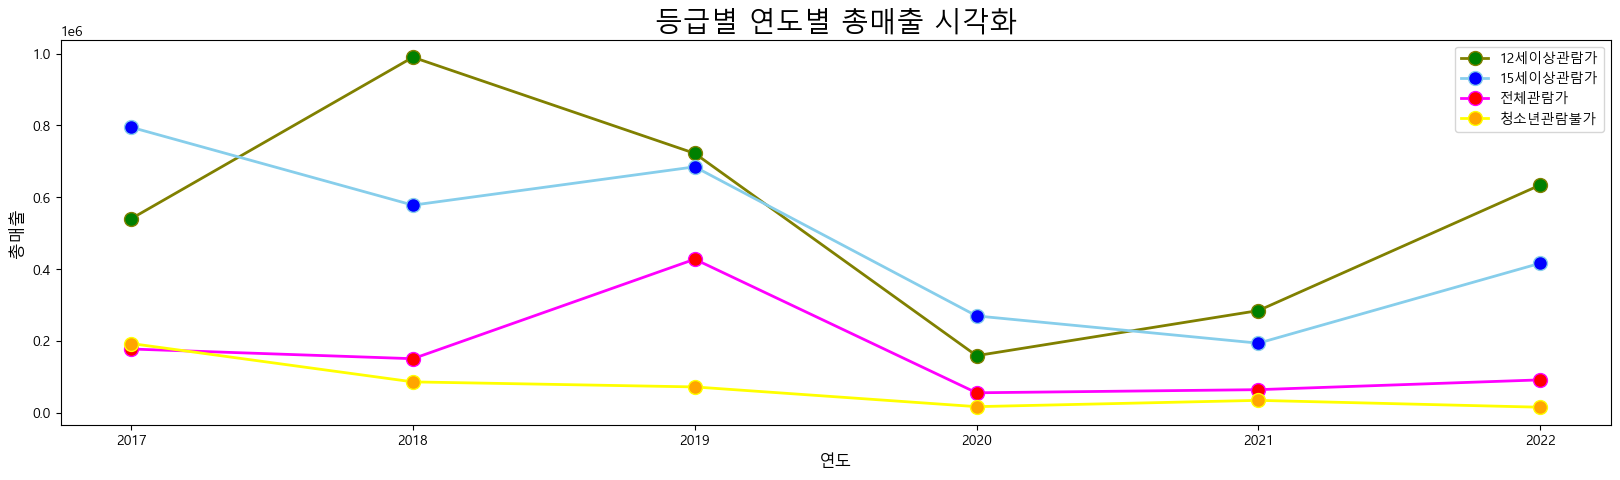

In [120]:
# 등급별 연도별 시각화
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)

grade_01 = grade_df_기준연도[grade_df_기준연도["등급"]=='12세이상관람가'][:-1]
grade_02 = grade_df_기준연도[grade_df_기준연도["등급"]=='15세이상관람가'][:-1]
grade_03 = grade_df_기준연도[grade_df_기준연도["등급"]=='전체관람가'][:-1]
grade_04 = grade_df_기준연도[grade_df_기준연도["등급"]=='청소년관람불가'][:-1]

ax.plot(grade_01['기준연도'], grade_01['총매출'], marker='o', markerfacecolor='green',
        markersize=10, color ="olive", linewidth=2, label='12세이상관람가')
ax.plot(grade_02['기준연도'], grade_02['총매출'], marker='o', markerfacecolor='blue',
        markersize=10, color ="skyblue", linewidth=2, label='15세이상관람가')
ax.plot(grade_03['기준연도'], grade_03['총매출'], marker='o', markerfacecolor='red',
        markersize=10, color ="magenta", linewidth=2, label='전체관람가')
ax.plot(grade_04['기준연도'], grade_04['총매출'], marker='o', markerfacecolor='orange',
        markersize=10, color ="yellow", linewidth=2, label='청소년관람불가')
ax.legend(loc="best")
ax.set_title('등급별 연도별 총매출 시각화', size=20)
ax.set_xlabel('연도',size=12)
ax.set_ylabel('총매출',size=12)
# ax.set_xticklabels(col_years, rotation = 90)
plt.show()

In [127]:
# 전체
grade_df_total = grade_df.groupby(['등급'])['매출액'].agg(['sum'])
grade_df_total

,sum
등급,
12세이상관람가,3586927572900
15세이상관람가,2981912008572
전체관람가,1010553852540
청소년관람불가,437018216622


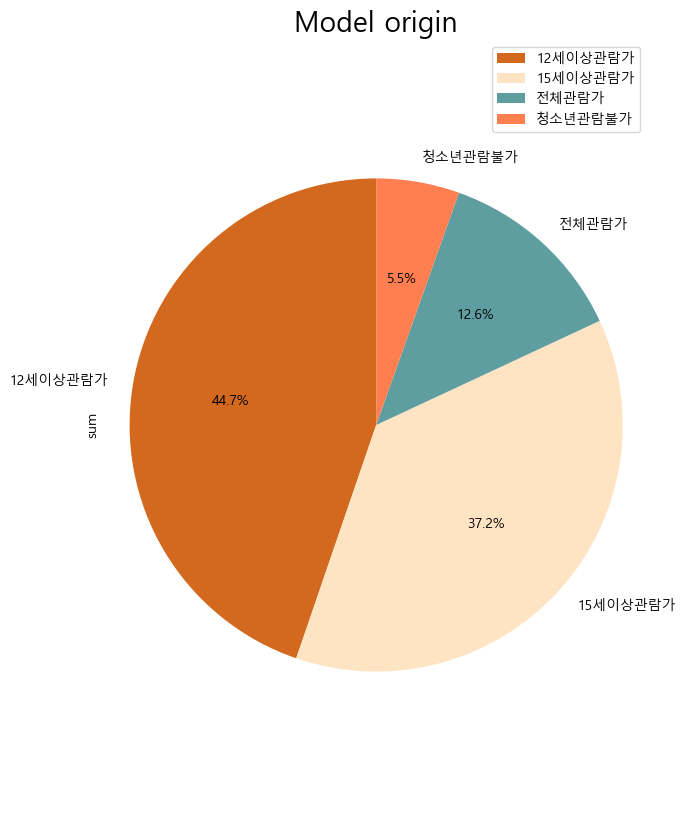

In [137]:
grade_df_total['sum'].plot(kind='pie', figsize=(7,10), autopct='%1.1f%%', 
                        startangle=90, # 파이조각을 나누는 시작점 (각도 표시)
                        colors=['chocolate','bisque','cadetblue','coral']) # 4개의 색상리스트
plt.title('Model origin', size=20)
plt.axis('equal') 
# 파이 차트의 비율을 같게(원에 가깝게) 조정
# 원의 형태를 유지할 수 있도록 써주는 것
plt.legend(labels = grade_df_total.index, loc='upper right')
plt.show()

# 2017년 이후 개봉한 영화 장르

In [187]:
sales_quarter_genre = movie_df[['영화명','개봉연도','개봉월','매출액','관객수','장르']]
sales_quarter_genre

,영화명,개봉연도,개봉월,매출액,관객수,장르
0,너의 이름은.,2017,1,2809088900,333008,"애니메이션,드라마,멜로/로맨스"
1,모아나,2017,1,7738000,910,애니메이션
2,패신저스,2017,1,1107502600,129810,"어드벤처,SF"
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,535436000,67605,"애니메이션,어드벤처,가족,판타지"
4,사랑하기 때문에,2017,1,450612400,53856,"코미디,멜로/로맨스"
...,...,...,...,...,...,...
183001,돈 지오반니,2017,1,4881000,209,공연
183002,걱정말아요,2017,1,502000,71,드라마
183003,비밀객잔의 결투,2017,1,7000,2,"액션,어드벤처,드라마"
183004,소림사 무림 탐정-취의전장,2017,1,7000,2,액션


In [188]:
def quarter_category(month):
    quarter = "-"
    if month <= 3:
        quarter = "1분기"
    elif month <= 6:
        quarter = "2분기"
    elif month <= 9:
        quarter = "3분기"
    elif month <= 12:
        quarter = "4분기"
    else:
        quarter = "-"
    return quarter

sales_quarter_genre['분기'] = sales_quarter_genre['개봉월'].apply(lambda x : quarter_category(x))
sales_quarter_genre.head(1)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_10188\1810076726.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_quarter_genre['분기'] = sales_quarter_genre['개봉월'].apply(lambda x : quarter_category(x))


,영화명,개봉연도,개봉월,매출액,관객수,장르,분기
0,너의 이름은.,2017,1,2809088900,333008,"애니메이션,드라마,멜로/로맨스",1분기


In [190]:
sales_quarter_genre.isnull().sum()

영화명       0
개봉연도      0
개봉월       0
매출액       0
관객수       0
장르      105
분기        0
dtype: int64

In [191]:
sales_quarter_genre = sales_quarter_genre[["영화명", "개봉연도", "개봉월", "분기", "매출액", "관객수", "장르"]]
sales_quarter_genre = sales_quarter_genre.dropna(subset=["장르"]).copy()
sales_quarter_genre

,영화명,개봉연도,개봉월,분기,매출액,관객수,장르
0,너의 이름은.,2017,1,1분기,2809088900,333008,"애니메이션,드라마,멜로/로맨스"
1,모아나,2017,1,1분기,7738000,910,애니메이션
2,패신저스,2017,1,1분기,1107502600,129810,"어드벤처,SF"
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,1분기,535436000,67605,"애니메이션,어드벤처,가족,판타지"
4,사랑하기 때문에,2017,1,1분기,450612400,53856,"코미디,멜로/로맨스"
...,...,...,...,...,...,...,...
183001,돈 지오반니,2017,1,1분기,4881000,209,공연
183002,걱정말아요,2017,1,1분기,502000,71,드라마
183003,비밀객잔의 결투,2017,1,1분기,7000,2,"액션,어드벤처,드라마"
183004,소림사 무림 탐정-취의전장,2017,1,1분기,7000,2,액션


In [192]:
sales_quarter['장르'].unique()

array(['애니메이션,드라마,멜로/로맨스', '애니메이션', '어드벤처,SF', '애니메이션,어드벤처,가족,판타지',
       '코미디,멜로/로맨스', '드라마', '공포(호러)', '액션', '액션,어드벤처,드라마',
       '스릴러,드라마,멜로/로맨스', '액션,어드벤처,판타지,SF', '어드벤처,스릴러', '다큐멘터리',
       '판타지,어드벤처,액션', '공연', '코미디', '멜로/로맨스', '범죄,드라마', '애니메이션,어드벤처,판타지',
       '드라마,스릴러', '공포(호러),스릴러', '스릴러', '멜로/로맨스,드라마', '성인물(에로)', '액션,전쟁',
       '액션,어드벤처,판타지', '액션,SF', '드라마,멜로/로맨스', '드라마,스릴러,미스터리',
       '애니메이션,SF,액션', '액션,범죄,스릴러', '범죄,액션', '애니메이션,액션,어드벤처', '애니메이션,가족',
       '드라마,전쟁', 'SF,액션,드라마', '드라마,범죄,미스터리', '판타지,액션',
       '애니메이션,어드벤처,가족,뮤지컬', '애니메이션,어드벤처', 'SF,드라마,스릴러', '액션,어드벤처,스릴러',
       '판타지,멜로/로맨스', '애니메이션,액션,코미디', '판타지,멜로/로맨스,코미디', '멜로/로맨스,스릴러',
       '애니메이션,드라마', 'SF,스릴러', '미스터리,멜로/로맨스,공포(호러)', '액션,드라마',
       '범죄,스릴러,드라마', '스릴러,드라마', '액션,범죄', '코미디,액션', '드라마,어드벤처',
       '멜로/로맨스,판타지,뮤지컬', '어드벤처,드라마,멜로/로맨스,SF', '액션,스릴러', '가족,드라마',
       '멜로/로맨스,코미디', '드라마,코미디', '미스터리,코미디', '액션,스릴러,드라마',
       '공포(호러),미스터리,스릴러', '애니메이션,코미디,액션', '애니메이션,판타지', '어드벤처', '판타지',
       '어드벤처,드

In [193]:
genre = []
for li in sales_quarter_genre['장르'].unique():
    if ',' in li:
        pass
    else:
        genre.append(li)
genre

['애니메이션',
 '드라마',
 '공포(호러)',
 '액션',
 '다큐멘터리',
 '공연',
 '코미디',
 '멜로/로맨스',
 '스릴러',
 '성인물(에로)',
 '어드벤처',
 '판타지',
 '기타',
 '범죄',
 'SF',
 '가족',
 '사극',
 '서부극(웨스턴)',
 '미스터리',
 '뮤지컬',
 '전쟁']

In [194]:
# 장르별 컬럼 만들기
for col in genre:
    sales_quarter_genre[col]=0
sales_quarter_genre.head()

,영화명,개봉연도,개봉월,분기,매출액,관객수,장르,애니메이션,드라마,공포(호러),...,판타지,기타,범죄,SF,가족,사극,서부극(웨스턴),미스터리,뮤지컬,전쟁
0,너의 이름은.,2017,1,1분기,2809088900,333008,"애니메이션,드라마,멜로/로맨스",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,모아나,2017,1,1분기,7738000,910,애니메이션,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,패신저스,2017,1,1분기,1107502600,129810,"어드벤처,SF",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,1분기,535436000,67605,"애니메이션,어드벤처,가족,판타지",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,사랑하기 때문에,2017,1,1분기,450612400,53856,"코미디,멜로/로맨스",0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [195]:
for col in genre:
    sales_quarter_genre[col]=sales_quarter_genre["장르"].apply(lambda x: 1 if col in x else 0)

In [196]:
sales_quarter_genre

,영화명,개봉연도,개봉월,분기,매출액,관객수,장르,애니메이션,드라마,공포(호러),...,판타지,기타,범죄,SF,가족,사극,서부극(웨스턴),미스터리,뮤지컬,전쟁
0,너의 이름은.,2017,1,1분기,2809088900,333008,"애니메이션,드라마,멜로/로맨스",1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,모아나,2017,1,1분기,7738000,910,애니메이션,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,패신저스,2017,1,1분기,1107502600,129810,"어드벤처,SF",0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,눈의 여왕 3: 눈과 불의 마법대결,2017,1,1분기,535436000,67605,"애니메이션,어드벤처,가족,판타지",1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,사랑하기 때문에,2017,1,1분기,450612400,53856,"코미디,멜로/로맨스",0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183001,돈 지오반니,2017,1,1분기,4881000,209,공연,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183002,걱정말아요,2017,1,1분기,502000,71,드라마,0,1,0,...,0,0,0,0,0,0,0,0,0,0
183003,비밀객잔의 결투,2017,1,1분기,7000,2,"액션,어드벤처,드라마",0,1,0,...,0,0,0,0,0,0,0,0,0,0
183004,소림사 무림 탐정-취의전장,2017,1,1분기,7000,2,액션,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [197]:
genre_df = sales_quarter_genre.iloc[:,7:]
total_genre = genre_df.sum(axis=0).to_frame()
total_genre.columns = ["장르"]
total_genre.sort_values(["장르"],axis=0, ascending=False, inplace=True)
len(total_genre)

21

In [278]:
# 색상 맵 선택
cmap = cm.get_cmap('tab20c')
colors = cmap(np.array(range(1,50)))

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_10188\1826526935.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c')


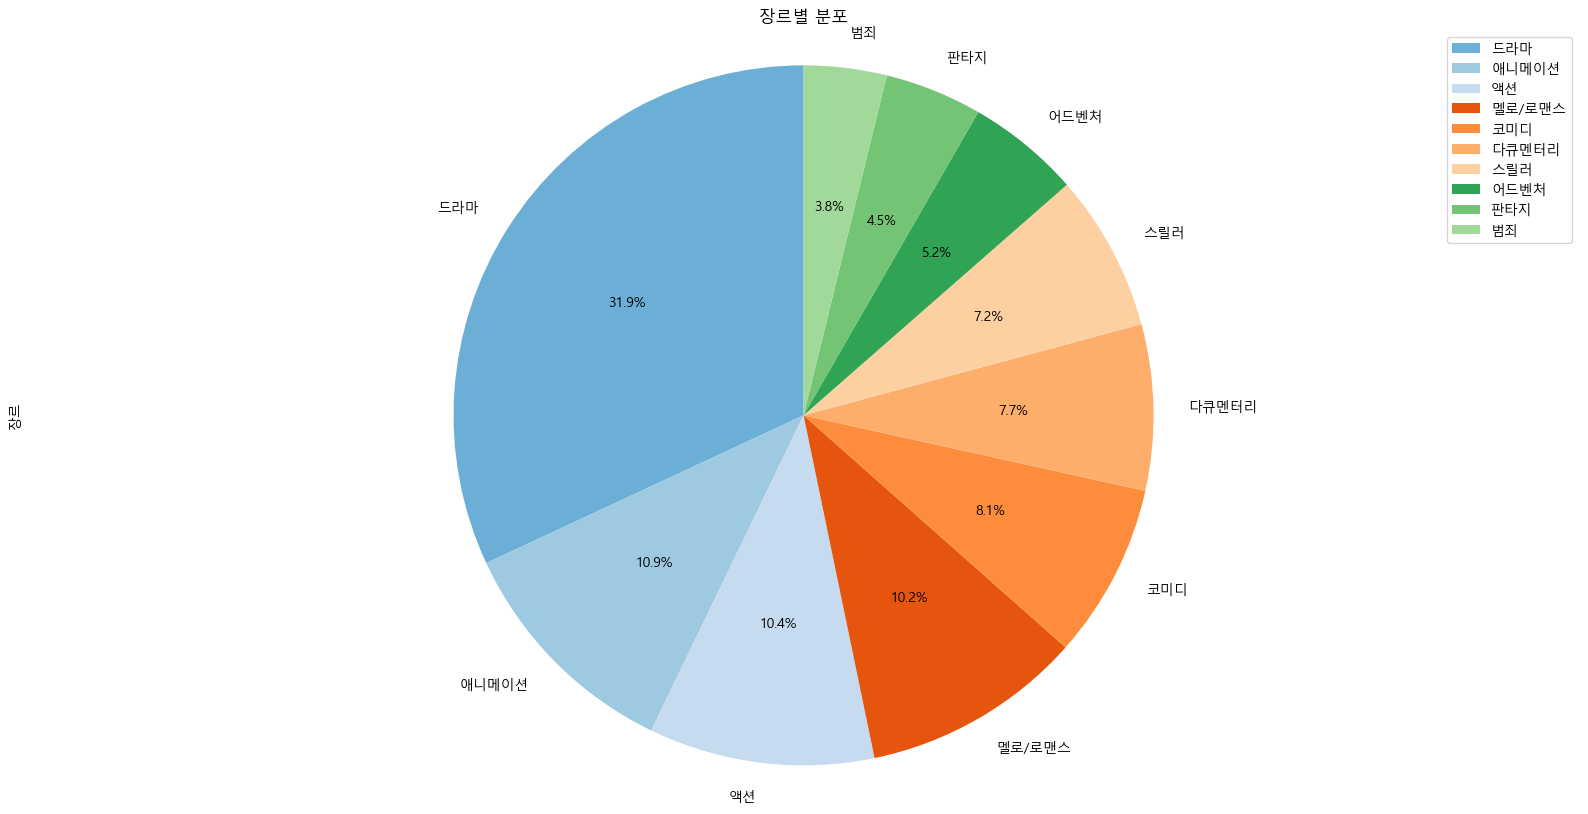

In [279]:
total_genre["장르"][:10].plot(kind='pie', figsize=(20,10), autopct='%1.1f%%', 
                        startangle=90, colors=colors)
plt.title('Model origin', size=20)
plt.axis('equal') 
plt.title("장르별 분포")
plt.legend(labels = total_genre.index, loc='upper right')
plt.show()

# 분기별 장르

In [202]:
quarter_genre = sales_quarter_genre[sales_quarter_genre['개봉연도']!=2023].groupby('분기')[genre].sum()
quarter_genre

,애니메이션,드라마,공포(호러),액션,다큐멘터리,공연,코미디,멜로/로맨스,스릴러,성인물(에로),...,판타지,기타,범죄,SF,가족,사극,서부극(웨스턴),미스터리,뮤지컬,전쟁
분기,,,,,,,,,,,,,,,,,,,,,
1분기,7444,20566,1478,5766,3455,729,4900,7454,4561,622,...,2692,175,2953,1533,1704,330,3,895,685,1041
2분기,5809,18242,1842,6642,5591,754,5087,4955,4169,681,...,2384,337,2422,1817,1868,82,54,1775,478,679
3분기,5811,17278,3136,6726,4382,643,5362,5026,4575,706,...,2374,504,2047,2010,1622,474,63,2390,836,567
4분기,7529,22005,1476,6456,5621,855,4559,7588,4612,610,...,3454,339,2121,2232,1403,307,120,1820,1784,543


In [280]:
quarter_genre_01 = quarter_genre.iloc[0].sort_values(ascending=False)[:10]
quarter_genre_02 = quarter_genre.iloc[1].sort_values(ascending=False)[:10]
quarter_genre_03 = quarter_genre.iloc[2].sort_values(ascending=False)[:10]
quarter_genre_04 = quarter_genre.iloc[3].sort_values(ascending=False)[:10]

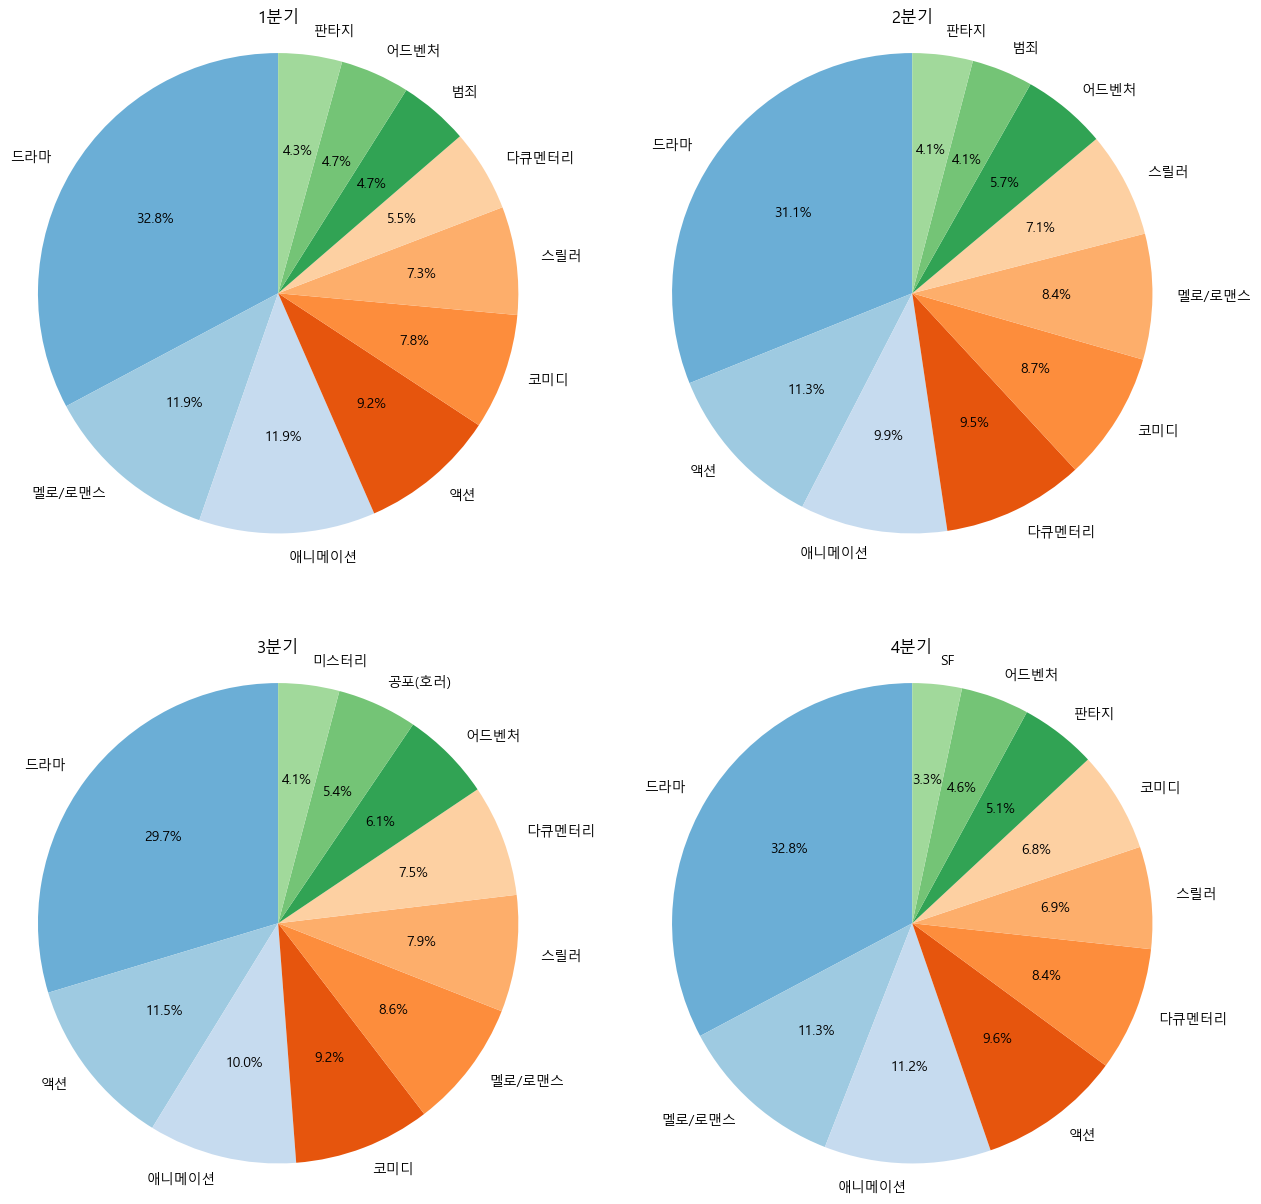

In [281]:
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.pie(quarter_genre_01.values.flatten(), labels=quarter_genre_01.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax2.pie(quarter_genre_02.values.flatten(), labels=quarter_genre_02.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax3.pie(quarter_genre_03.values.flatten(), labels=quarter_genre_03.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)
ax4.pie(quarter_genre_04.values.flatten(), labels=quarter_genre_04.index, autopct='%1.1f%%', 
                        startangle=90, colors=colors)

ax1.set_title('1분기')
ax1.axis('equal')
ax2.set_title('2분기')
ax2.axis('equal')
ax3.set_title('3분기')
ax3.axis('equal')
ax4.set_title('4분기')
ax4.axis('equal')

plt.show()

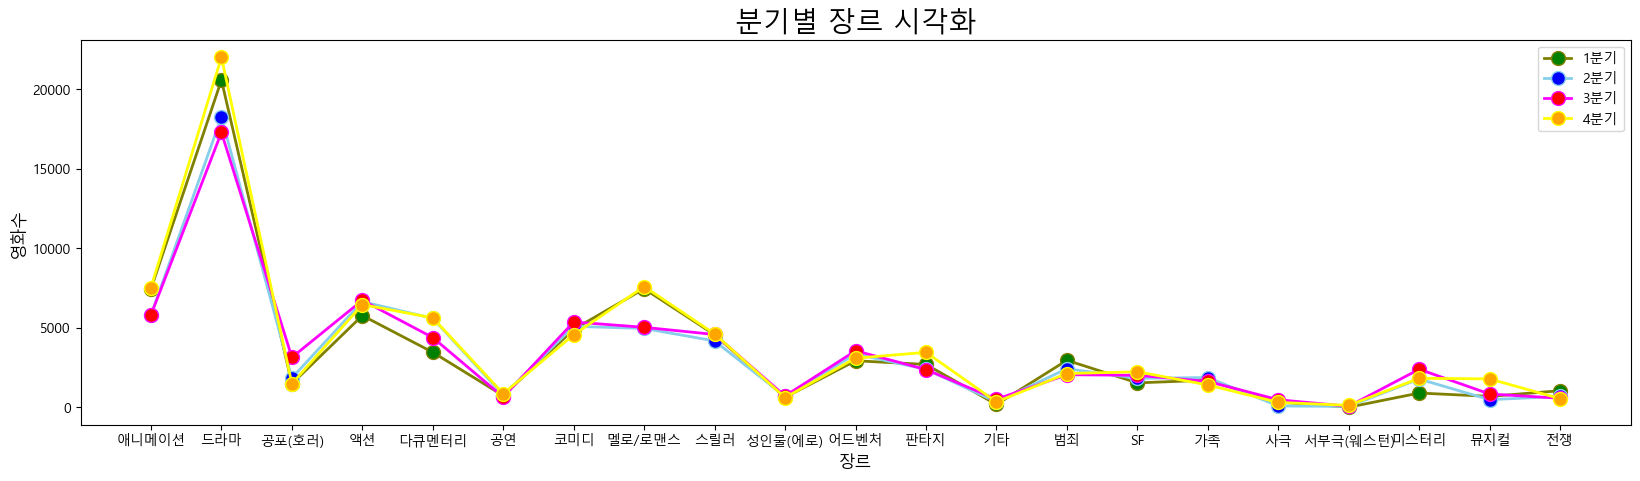

In [282]:
# 등급별 연도별 시각화
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,1,1)

quarter_genre_01 = quarter_genre.iloc[0].to_frame()
quarter_genre_02 = quarter_genre.iloc[1].to_frame()
quarter_genre_03 = quarter_genre.iloc[2].to_frame()
quarter_genre_04 = quarter_genre.iloc[3].to_frame()

ax.plot(quarter_genre_01.index, quarter_genre_01['1분기'], marker='o', markerfacecolor='green',
        markersize=10, color ="olive", linewidth=2, label='1분기')
ax.plot(quarter_genre_02.index, quarter_genre_02['2분기'], marker='o', markerfacecolor='blue',
        markersize=10, color ="skyblue", linewidth=2, label='2분기')
ax.plot(quarter_genre_03.index, quarter_genre_03['3분기'], marker='o', markerfacecolor='red',
        markersize=10, color ="magenta", linewidth=2, label='3분기')
ax.plot(quarter_genre_04.index, quarter_genre_04['4분기'], marker='o', markerfacecolor='orange',
        markersize=10, color ="yellow", linewidth=2, label='4분기')
ax.legend(loc="best")
ax.set_title('분기별 장르 시각화', size=20)
ax.set_xlabel('장르',size=12)
ax.set_ylabel('영화수',size=12)
# ax.set_xticklabels(col_years, rotation = 90)
plt.show()

# 개봉 10일동안 매출

In [81]:
open_ten = movie_df[["영화명", '개봉일','기준일','대표국적', '등급','매출액','누적매출액','관객수','누적관객수','스크린수','상영횟수','개봉연도']]
open_ten = open_ten[(open_ten["개봉연도"]!=2023)&(open_ten["개봉연도"]!=2017)]
open_ten.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143518 entries, 366 to 182893
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   영화명     143518 non-null  object        
 1   개봉일     143518 non-null  datetime64[ns]
 2   기준일     143518 non-null  datetime64[ns]
 3   대표국적    143518 non-null  object        
 4   등급      143516 non-null  object        
 5   매출액     143518 non-null  int64         
 6   누적매출액   143518 non-null  int64         
 7   관객수     143518 non-null  int64         
 8   누적관객수   143518 non-null  int64         
 9   스크린수    143518 non-null  int64         
 10  상영횟수    143518 non-null  int64         
 11  개봉연도    143518 non-null  int64         
dtypes: datetime64[ns](2), int64(7), object(3)
memory usage: 14.2+ MB


In [82]:
open_ten = open_ten[open_ten['개봉일']<=open_ten['기준일']]
open_ten = open_ten[open_ten['개봉일']+timedelta(9)>=open_ten['기준일']]
open_ten

,영화명,개봉일,기준일,대표국적,등급,매출액,누적매출액,관객수,누적관객수,스크린수,상영횟수,개봉연도
666,국가부도의 날,2018-11-28,2018-12-02,한국,12세이상관람가,3542110050,12758179511,400083,1571881,1152,6166,2018
670,후드,2018-11-28,2018-12-02,미국,12세이상관람가,405724000,1775841549,46476,227258,603,1605,2018
674,투 프렌즈,2018-11-29,2018-12-02,러시아,전체관람가,62638350,153100650,8120,20419,273,330,2018
675,거미줄에 걸린 소녀,2018-11-28,2018-12-02,미국,15세이상관람가,41766500,200609650,4825,25172,264,385,2018
678,일곱 개의 대죄 : 천공의 포로,2018-11-29,2018-12-02,일본,15세이상관람가,18015000,67794200,2253,8613,88,137,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
172962,이스터 선데이,2022-12-28,2023-01-06,미국,12세이상관람가,36000,4302800,5,443,2,2,2022
173014,이태석,2022-12-29,2023-01-07,한국,전체관람가,561000,45487797,140,5228,7,10,2022
173016,메모리아,2022-12-29,2023-01-07,기타,12세이상관람가,3043400,40510386,295,4326,27,32,2022
173036,희망의 요소,2022-12-29,2023-01-07,한국,12세이상관람가,489000,3002000,60,372,4,4,2022


In [83]:
sum_over = movie_df.groupby(['영화명'])['누적매출액'].max().to_frame().reset_index()
sum_over

,영화명,누적매출액
0,#살아있다,15968219900
1,#아이엠히어,136875710
2,#위왓치유,16759950
3,#해시태그,2205600
4,0.0MHz,1088258860
...,...,...
11548,힐빌리의 노래,34016080
11549,힘 좋은 시아버지와 착한 며느리,100000
11550,"힘을 내요, 미스터 리",9930518906
11551,힘좋은 시아버지와 베란다,6000


In [84]:
open_ten_df = open_ten.groupby(['영화명','개봉일','기준일'])['매출액'].sum().to_frame().reset_index()
open_ten_df

,영화명,개봉일,기준일,매출액
0,#살아있다,2020-06-24,2020-06-24,1311296000
1,#살아있다,2020-06-24,2020-06-25,1240607900
2,#살아있다,2020-06-24,2020-06-26,1380200100
3,#살아있다,2020-06-24,2020-06-27,2644122800
4,#살아있다,2020-06-24,2020-06-28,2263447540
...,...,...,...,...
36133,"힘을 내요, 미스터 리",2019-09-11,2019-09-17,307029080
36134,"힘을 내요, 미스터 리",2019-09-11,2019-09-18,178146970
36135,"힘을 내요, 미스터 리",2019-09-11,2019-09-19,132629460
36136,"힘을 내요, 미스터 리",2019-09-11,2019-09-20,168461600


In [72]:
not_ten = open_ten.groupby(['영화명','개봉일'])['매출액'].agg(['count','sum']).reset_index()
not_ten_list = not_ten[not_ten['count']!=10]['영화명'].to_list()

In [85]:
open_ten_df_total = open_ten_df.groupby(["영화명",'개봉일']).agg({'매출액':['size','sum']}).reset_index()
open_ten_df_total.columns=['영화명','개봉일','일수','총매출']
open_ten_df_total.sort_values(['총매출'],axis=0,ascending=False)[:50]

,영화명,개봉일,일수,총매출
5616,어벤져스: 엔드게임,2019-04-24,10,78990047980
4888,신과함께-인과 연,2018-08-01,10,69553512985
431,겨울왕국 2,2019-11-21,10,63274811030
5617,어벤져스: 인피니티 워,2018-04-25,10,60844460684
886,기생충,2019-05-30,10,55744007185
3400,범죄도시2,2022-05-18,10,50663413240
5179,아바타: 물의 길,2022-12-14,10,48777881989
4769,스파이더맨: 파 프롬 홈,2019-07-02,10,45710069850
1650,닥터 스트레인지: 대혼돈의 멀티버스,2022-05-04,10,45120695940
3361,백두산,2019-12-19,10,44309559050


In [87]:
open_ten_df_total[open_ten_df_total['영화명']=='헌트']

,영화명,개봉일,일수,총매출
9067,헌트,2020-04-23,10,37413660
9068,헌트,2022-08-10,10,25252375771


In [74]:
open_ten_df_total_df = pd.merge(open_ten_df_total, sum_over, left_on="영화명", right_on="영화명", how="left")
open_ten_df_total_df

,영화명,개봉일,일수,총매출,누적매출액
0,#살아있다,2020-06-24,10,11205018180,15968219900
1,#아이엠히어,2021-01-14,10,125890760,136875710
2,#위왓치유,2021-06-03,10,8309450,16759950
3,#해시태그,2022-06-01,7,2205600,2205600
4,0.0MHz,2019-05-29,10,999517960,1088258860
...,...,...,...,...,...
9335,힐링하우스 : 섹스의 왕국,2022-05-10,1,6000,6000
9336,힐빌리의 노래,2020-11-11,10,27858780,34016080
9337,힘 좋은 시아버지와 착한 며느리,2021-03-18,1,100000,100000
9338,"힘을 내요, 미스터 리",2019-09-11,10,8493654186,9930518906


In [75]:
open_ten_df_total_df['비중']=round(open_ten_df_total_df['총매출']/open_ten_df_total_df['누적매출액'],2)

In [76]:
open_top_30 = open_ten_df_total_df.sort_values(['총매출'],axis=0,ascending=False)[:30]
open_top_30

,영화명,개봉일,일수,총매출,누적매출액,비중
5616,어벤져스: 엔드게임,2019-04-24,10,78990047980,122492181020,0.64
4888,신과함께-인과 연,2018-08-01,10,69553512985,102689349539,0.68
431,겨울왕국 2,2019-11-21,10,63274811030,114843932550,0.55
5617,어벤져스: 인피니티 워,2018-04-25,10,60844460684,100081428549,0.61
886,기생충,2019-05-30,10,55744007185,87463965795,0.64
3400,범죄도시2,2022-05-18,10,50663413240,131298796478,0.39
5179,아바타: 물의 길,2022-12-14,10,48777881989,137647454399,0.35
4769,스파이더맨: 파 프롬 홈,2019-07-02,10,45710069850,69033177100,0.66
1650,닥터 스트레인지: 대혼돈의 멀티버스,2022-05-04,10,45120695940,62648728870,0.72
3361,백두산,2019-12-19,10,44309559050,69831430800,0.63


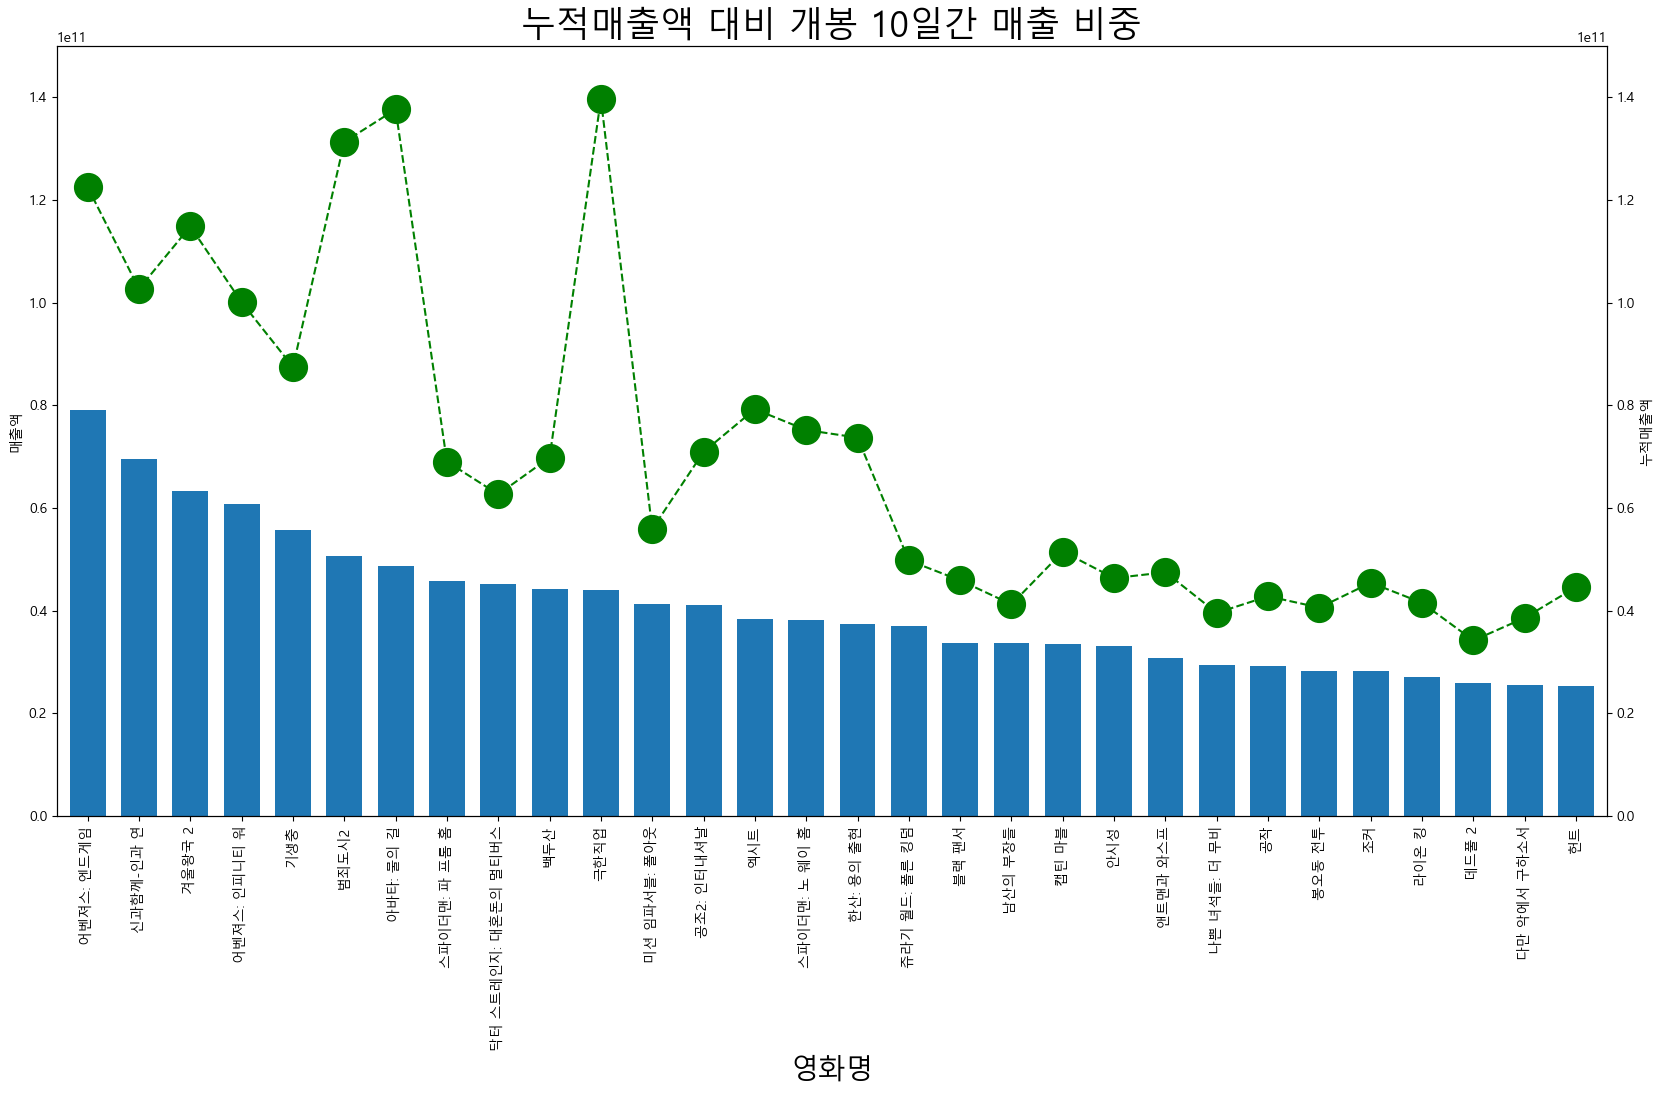

In [77]:
# 2축 그래프 그리기
ax1 = open_top_30.set_index(['영화명'])['총매출'].plot(kind='bar', figsize=(20,10), width=0.7)
ax2 = ax1.twinx() # 여러 개의 그래프를 한 화면에 나타내기
ax2.plot(open_top_30['영화명'], open_top_30.누적매출액, ls='--', marker='o', markersize=20,
         color='green', label='누적매출액') 

ax1.set_ylim(0, 150000000000)
ax2.set_ylim(0, 150000000000)

ax1.set_xlabel('영화명', size=20)
ax1.set_ylabel('매출액')
ax2.set_ylabel('누적매출액')
plt.title('누적매출액 대비 개봉 10일간 매출 비중', size=25)
plt.show()

In [78]:
# 누적매출액순
open_over_top_30 = open_ten_df_total_df.sort_values(['누적매출액'],axis=0,ascending=False)[:30]
open_over_top_30

,영화명,개봉일,일수,총매출,누적매출액,비중
829,극한직업,2019-01-23,10,43938488018,139655543516,0.31
5179,아바타: 물의 길,2022-12-14,10,48777881989,137647454399,0.35
3400,범죄도시2,2022-05-18,10,50663413240,131298796478,0.39
5616,어벤져스: 엔드게임,2019-04-24,10,78990047980,122492181020,0.64
431,겨울왕국 2,2019-11-21,10,63274811030,114843932550,0.55
5324,알라딘,2019-05-23,10,15391548872,109041960039,0.14
4888,신과함께-인과 연,2018-08-01,10,69553512985,102689349539,0.68
5617,어벤져스: 인피니티 워,2018-04-25,10,60844460684,100081428549,0.61
8483,탑건: 매버릭,2022-06-22,10,24997969340,88057840494,0.28
886,기생충,2019-05-30,10,55744007185,87463965795,0.64


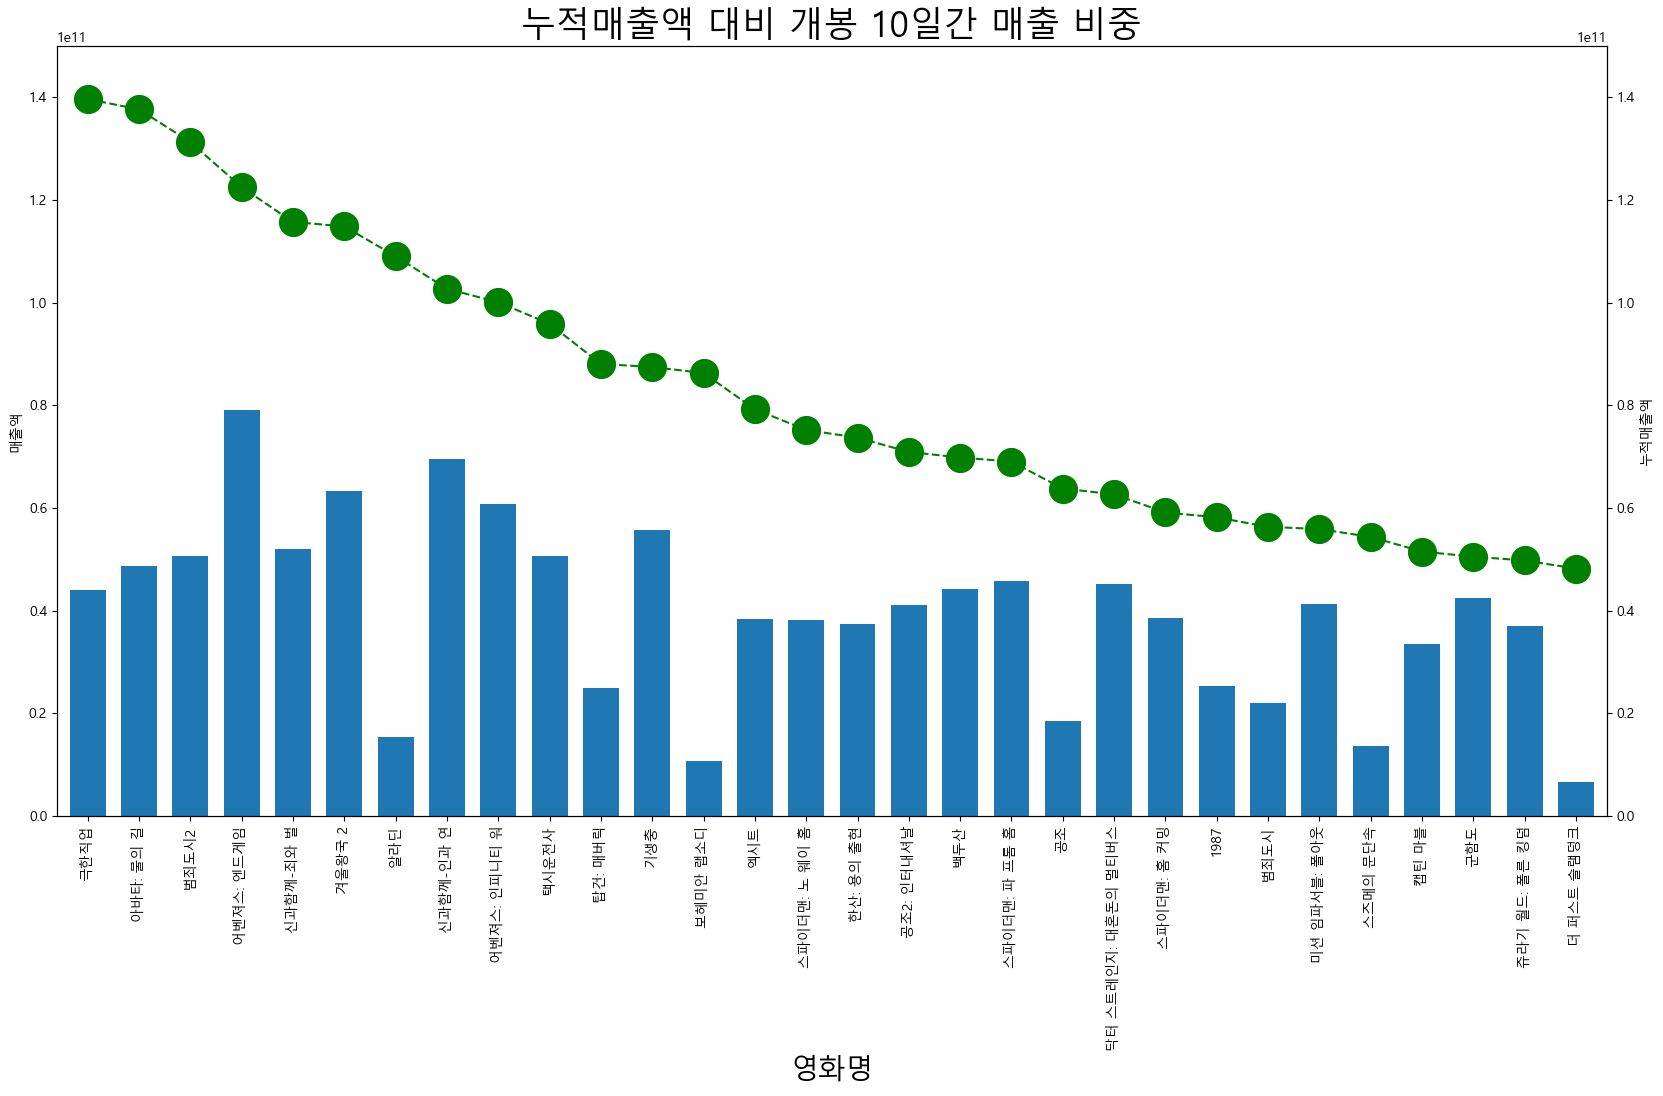

In [52]:
# 2축 그래프 그리기
ax1 = open_over_top_30.set_index(['영화명'])['총매출'].plot(kind='bar', figsize=(20,10), width=0.7)
ax2 = ax1.twinx() # 여러 개의 그래프를 한 화면에 나타내기
ax2.plot(open_over_top_30['영화명'], open_over_top_30.누적매출액, ls='--', marker='o', markersize=20,
         color='green', label='누적매출액') 

ax1.set_ylim(0, 150000000000)
ax2.set_ylim(0, 150000000000)

ax1.set_xlabel('영화명', size=20)
ax1.set_ylabel('매출액')
ax2.set_ylabel('누적매출액')
plt.title('누적매출액 대비 개봉 10일간 매출 비중', size=25)
plt.show()

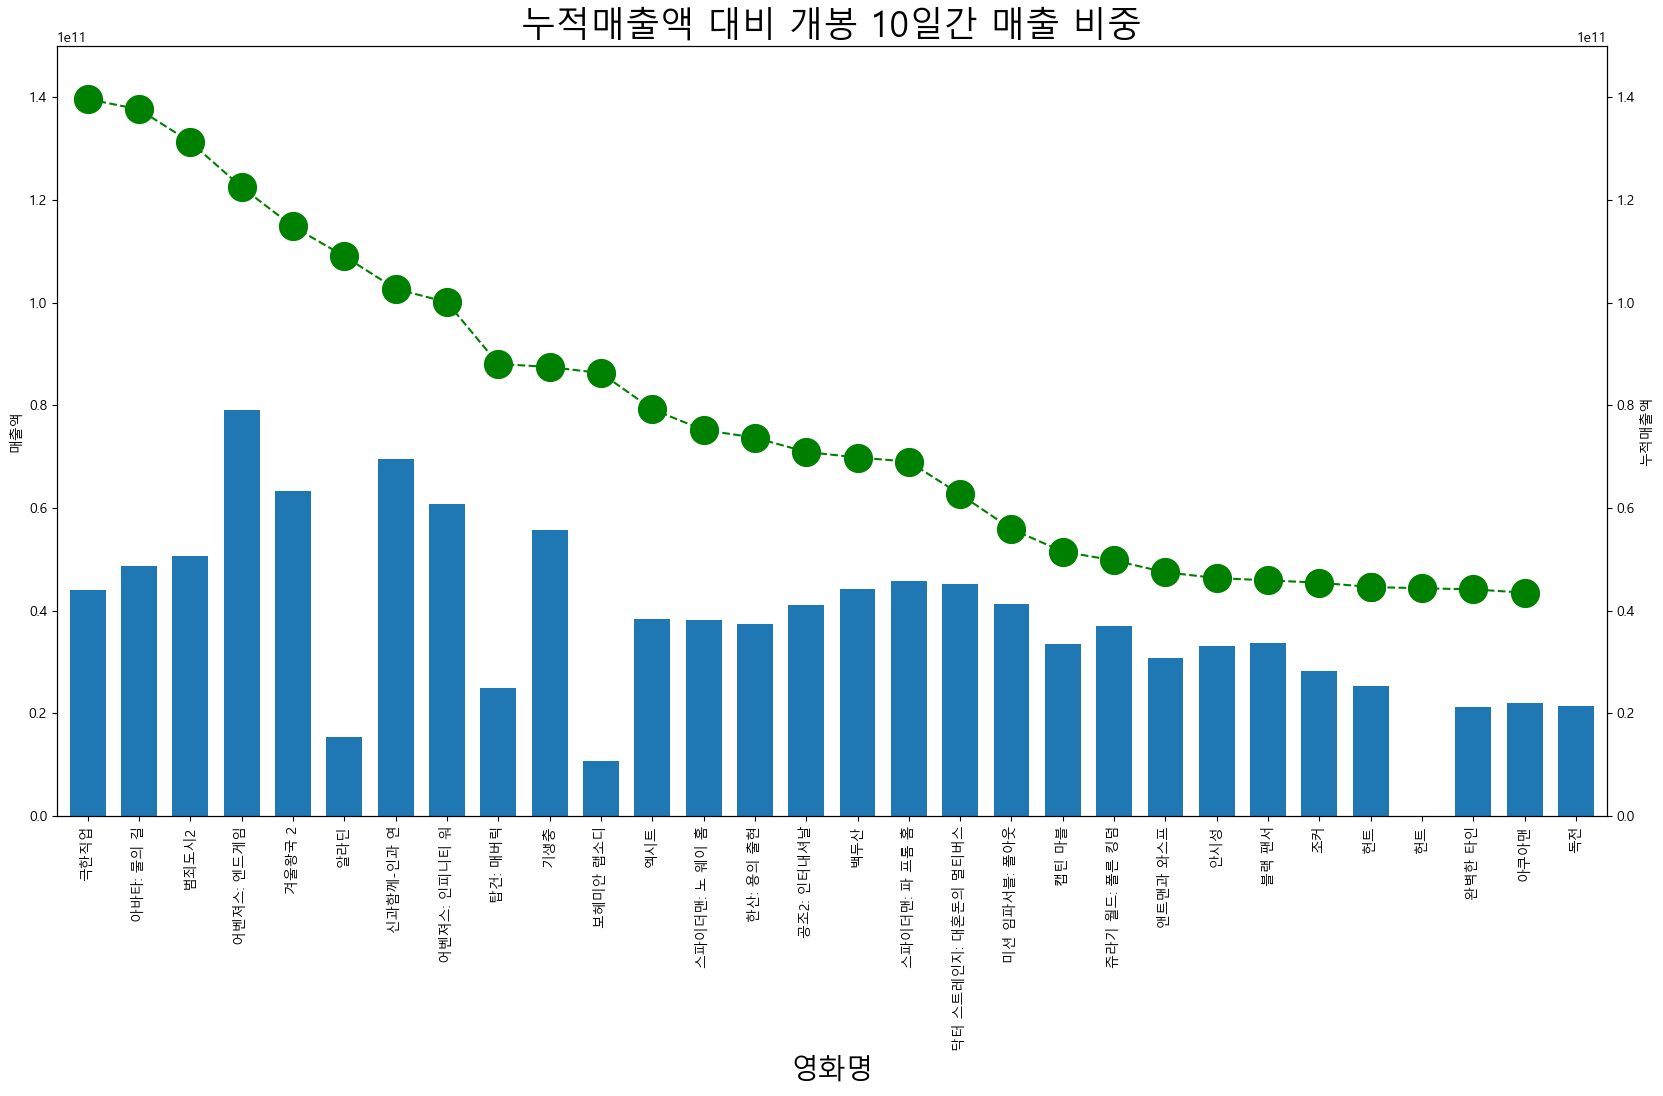

In [79]:
# 2축 그래프 그리기
ax1 = open_over_top_30.set_index(['영화명'])['총매출'].plot(kind='bar', figsize=(20,10), width=0.7)
ax2 = ax1.twinx() # 여러 개의 그래프를 한 화면에 나타내기
ax2.plot(open_over_top_30['영화명'], open_over_top_30.누적매출액, ls='--', marker='o', markersize=20,
         color='green', label='누적매출액') 

ax1.set_ylim(0, 150000000000)
ax2.set_ylim(0, 150000000000)

ax1.set_xlabel('영화명', size=20)
ax1.set_ylabel('매출액')
ax2.set_ylabel('누적매출액')
plt.title('누적매출액 대비 개봉 10일간 매출 비중', size=25)
plt.show()

# 개봉 후 첫 주말